# Setup

In [1]:
# import packages
%run ../global_packages.py

# get the global parameters
%run ../global_pars.py

# import your local functions
sys.path.insert(1, '../')
from global_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Paths

In [2]:
figpath = '../figures/'

# S13 - SLA Detrending

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


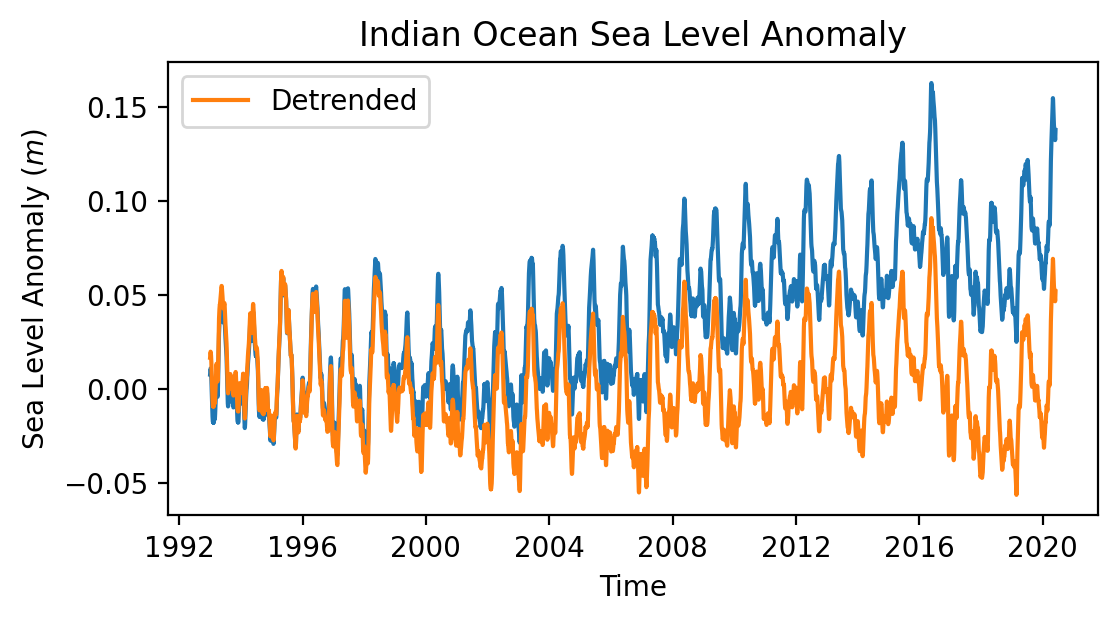

In [6]:
inpath = '../data_processing/2_SLA/raw_data/concatenated/'
infn = 'sla_dt_global_twosat_phy_l4__vDT2018_19930101_to_20200603.nc'
ds = xr.open_dataset(inpath + infn)

# Subset ------------------------------------------------#
lat_slice = slice(lat_bounds[0], lat_bounds[1])
lon_slice = slice(lon_bounds[0], lon_bounds[1])
time_slice = slice(ts,te)

ds = ds.sel(lat=lat_slice,lon=lon_slice, time = time_slice)

# Get daily sla
daily_sla = ds['sla']
lat = daily_sla.lat.values
lon = daily_sla.lon.values

# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['lat','lon'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

# find global means for comparison
stacked = daily_sla.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
# global_mean.plot()

# find global means for comparison 
stacked = daily_sla_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
# global_mean_dtrnd.plot()
# plt.legend


fig = plt.figure(figsize=(6,3),dpi=200)
plt.plot(global_mean.time,global_mean)
plt.plot(global_mean_dtrnd.time,global_mean_dtrnd, label = 'Detrended')
plt.legend()
plt.title('Indian Ocean Sea Level Anomaly')
plt.ylabel('Sea Level Anomaly ($m$)')
plt.xlabel('Time')

plt.savefig(figpath + 'Fig_S13_sla_detrending.pdf', format='pdf', dpi = 400)

# S14 - DMI over time

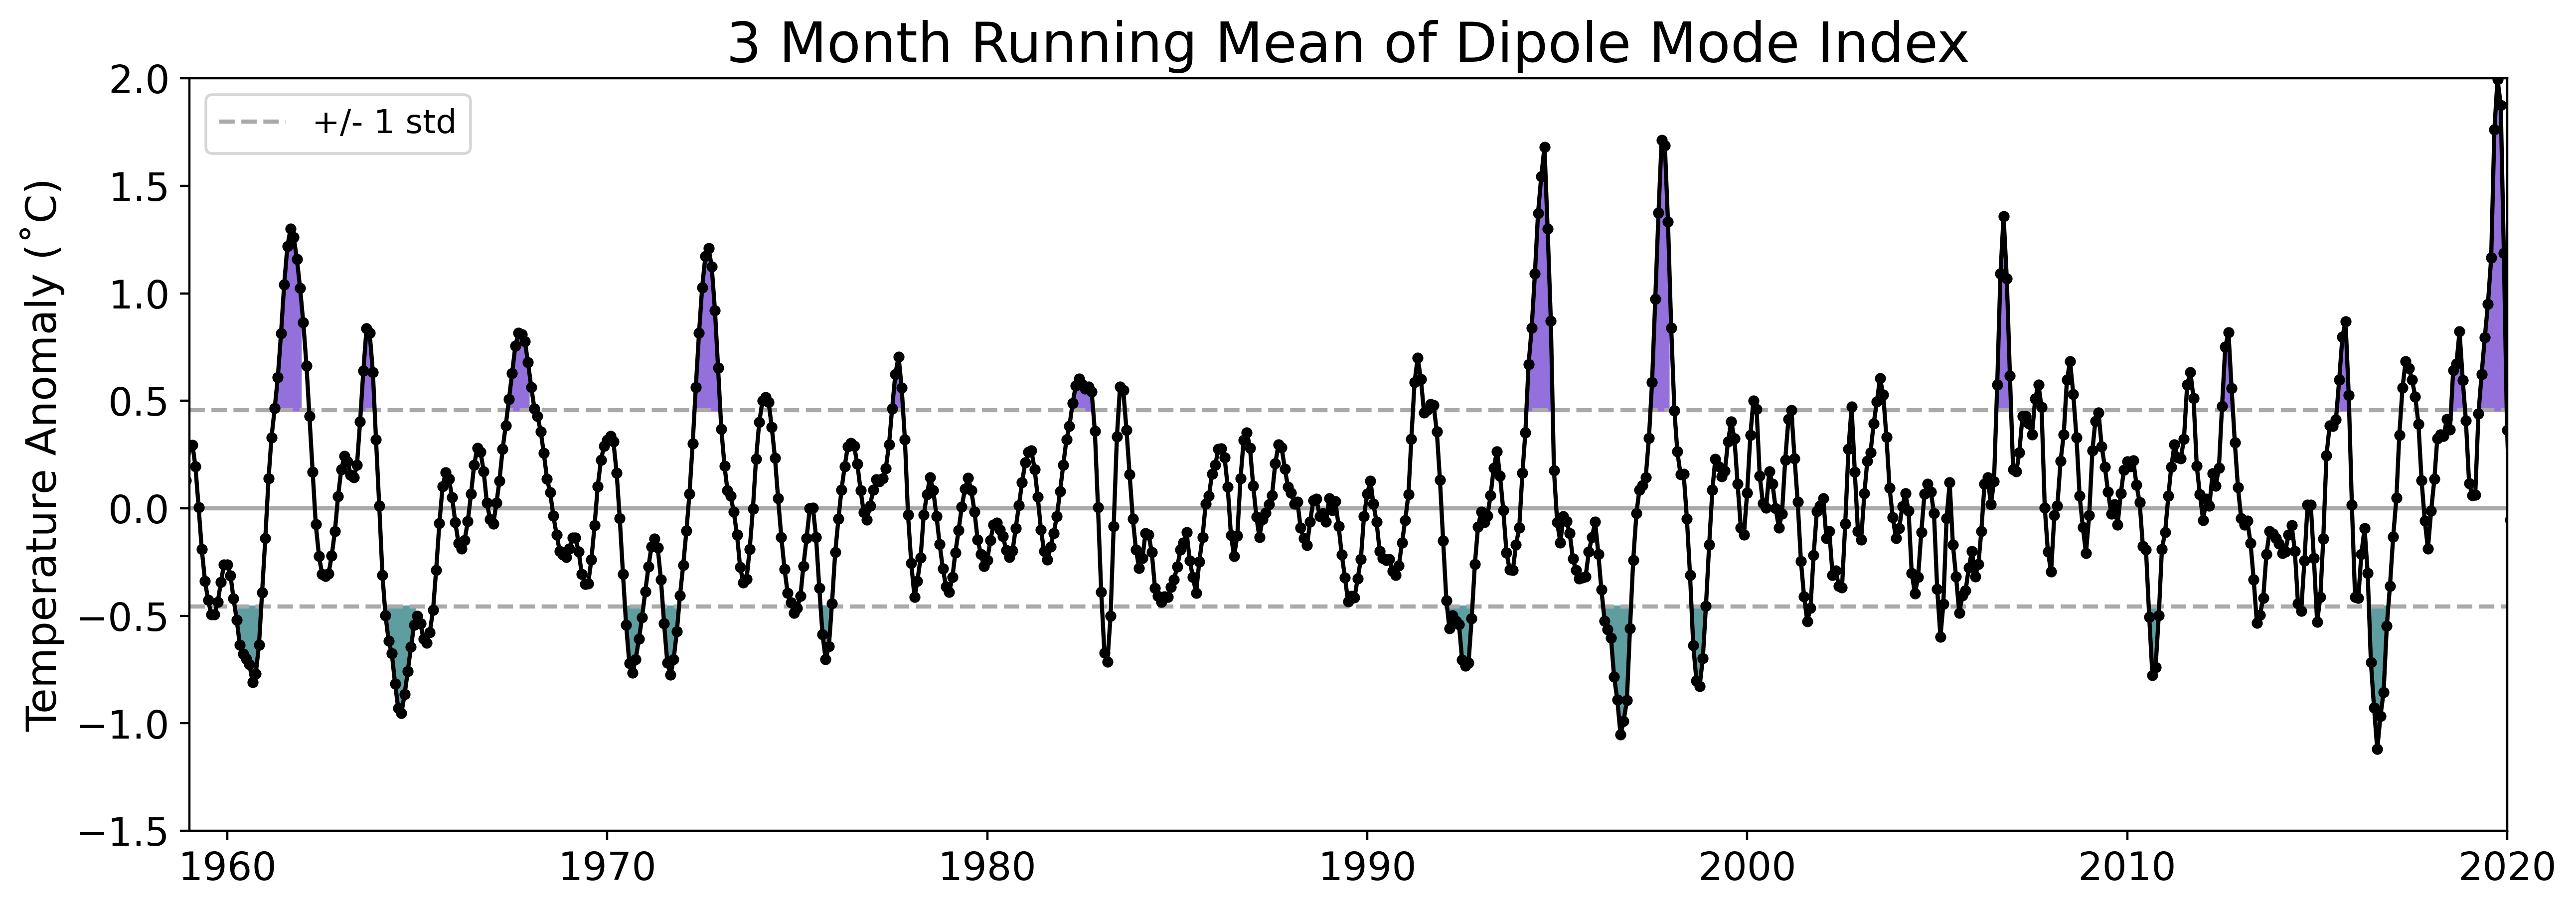

In [7]:
# load DMI data
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years)) #[1994,1997,2006,2012,2015]
negIODyears = list(np.array(ds_DMI.neg_IOD_years)) #[1996,1998,2001,2010,2014,2016]
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) # [1995,1999,2000,2002,2003,2004,2005,2007,2008,2009,2011,2012,2013]

sposIODyears = list(np.array(ds_DMI.spos_IOD_years)) 
snegIODyears = list(np.array(ds_DMI.sneg_IOD_years)) 

wposIODyears = list(np.array(ds_DMI.wpos_IOD_years)) 
wnegIODyears = list(np.array(ds_DMI.wneg_IOD_years)) 


# plot before combining into one

params = {'legend.fontsize': 12,
         'axes.labelsize': 15,
         'axes.titlesize': 20,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

pylab.rcParams.update(params)

fig = plt.figure(figsize=(15, 5), dpi = 400)
plt.axhline(y=0, color='darkgray', linestyle='-')
std1 = plt.axhline(y=ds_DMI.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
plt.axhline(y=-ds_DMI.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
# std2 = plt.axhline(y=ds_DMI.dmi_3mo_runmean.std()*2, color='lightblue', linestyle='--')
# plt.axhline(y=-ds_DMI.dmi_3mo_runmean.std()*1.5, color='lightblue', linestyle='--')
plt.plot(ds_DMI.time,ds_DMI.dmi_3mo_runmean, marker = '.',color='k')

for posyear in ds_DMI.pos_IOD_years:
    
    ind = ds_DMI.time.dt.year == posyear
    x = np.array(ds_DMI.time[ind])
    y2 = np.array(ds_DMI.dmi_3mo_runmean.std())
    y1 = np.array(ds_DMI.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'mediumpurple')
    
for negyear in ds_DMI.neg_IOD_years:
    
    ind = ds_DMI.time.dt.year == negyear
    x = np.array(ds_DMI.time[ind])
    y1 = -np.array(ds_DMI.dmi_3mo_runmean.std())
    y2 = np.array(ds_DMI.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'cadetblue')
# add_text(plt.gca(), str(len(ds_DMI.posyears)) + ' Postive IOD Years', x = 0.16,y=0.05, fontsize = 14)
# add_text(plt.gca(), str(len(ds_DMI.negyears)) + ' Negative IOD Years', x = 0.415,y=0.05, fontsize = 14)
# add_text(plt.gca(), str(len(ds_DMI.neuyears)) + ' Neutral IOD Years', x = 0.685,y=0.05, fontsize = 14)
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylim([-1.5,2])
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('3 Month Running Mean of Dipole Mode Index')

l = plt.legend([std1],['+/- 1 std'],facecolor = 'w', loc = 'upper left')


plt.savefig(figpath + 'Fig_S14_dmi.pdf', format='pdf', dpi = 400)

# S15 - Empircal Cumulative Disitrbution Functions

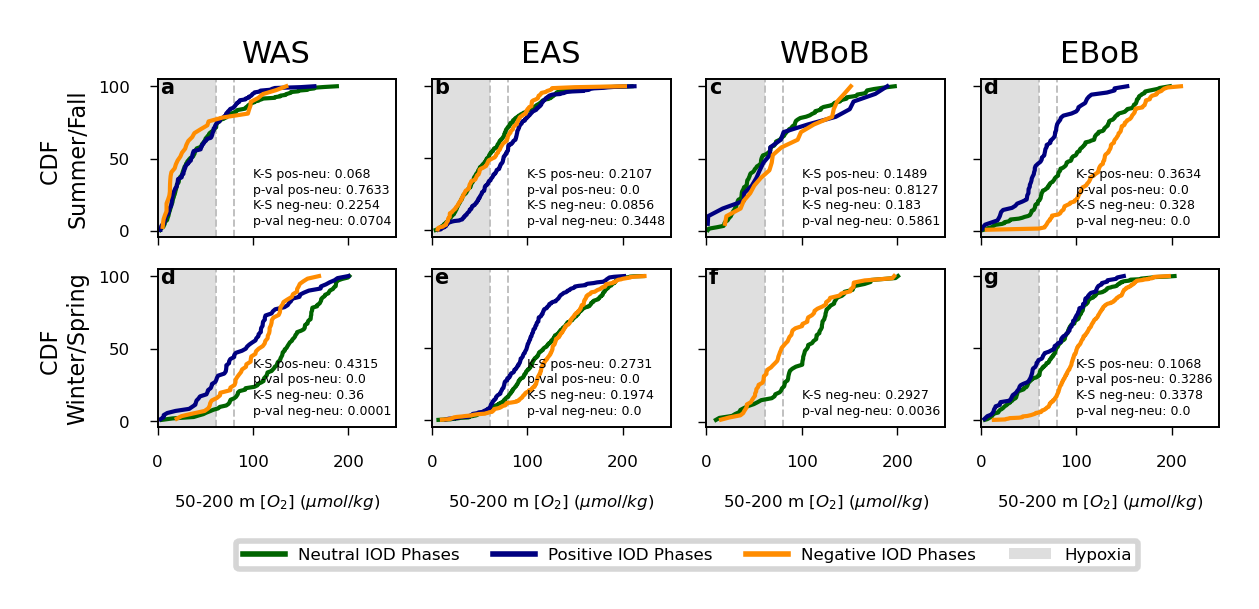

In [8]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# DMI
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
sposIODyears = list(np.array(ds_DMI.spos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

depth = '50_200'
Depth = '50-200'
############################################################################################################
# Western Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_wAS_' + depth]
lat = ds_WOD.lat_wAS
lon = ds_WOD.lon_wAS
t = ds_WOD.time_wAS

# positive IOD years -------------------------------------------# 
posIODdata_wAS,_,_,posIODtime_wAS,posIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wAS')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wAS,_,_,sposIODtime_wAS,sposIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wAS')

# negative IOD years -------------------------------------------# 
negIODdata_wAS,_,_,_,negIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_wAS,_,_,_,neuIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wAS')

############################################################################################################
# Eastern Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_eAS_' + depth]
lat = ds_WOD.lat_eAS
lon = ds_WOD.lon_eAS
t = ds_WOD.time_eAS

# positive IOD years -------------------------------------------# 
posIODdata_eAS,_,_,_,posIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eAS')

# strong positive IOD years -------------------------------------------# 
sposIODdata_eAS,_,_,_,sposIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eAS')

# negative IOD years -------------------------------------------# 
negIODdata_eAS,_,_,_,negIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_eAS,_,_,_,neuIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eAS')

############################################################################################################
# Western Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_wBoB_' + depth]
lat = ds_WOD.lat_wBoB
lon = ds_WOD.lon_wBoB
t = ds_WOD.time_wBoB

# positive IOD years -------------------------------------------# 
posIODdata_wBoB,_,_,_,posIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wBoB,_,_,_,sposIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wBoB')
# negative IOD years -------------------------------------------# 
negIODdata_wBoB,_,_,_,negIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_wBoB,_,_,_,neuIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wBoB')

############################################################################################################
# Eastern Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_eBoB_' + depth]
lat = ds_WOD.lat_eBoB
lon = ds_WOD.lon_eBoB
t = ds_WOD.time_eBoB

# positive IOD years -------------------------------------------# 
posIODdata_eBoB,_,_,_,posIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_eBoB,_,_,_,sposIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eBoB')
# negative IOD years -------------------------------------------# 
negIODdata_eBoB,_,_,_,negIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_eBoB,_,_,_,neuIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eBoB')


# Make Histograms 
# hatch_mask = min_mean > hyp_thresh
x = [1,2,3,4]

fig = plt.figure(figsize=(8.7 / 2.54, 1.5), dpi=400)

params = {'legend.fontsize': 3,
         'axes.labelsize': 3.5,
         'axes.titlesize': 5.5,
         'xtick.labelsize':3,
         'ytick.labelsize':3,
         'axes.linewidth':0.35,
         'xtick.major.width':0.25,
         'xtick.major.size':1.5,
         'ytick.major.width':0.25,
         'ytick.major.size':1.5}

pylab.rcParams.update(params)

text_fz = 4.5
sq_sz = 20
lfz = 3.75
width = 0.2
lw = 0.75

clrs = ['darkgreen','navy','darkorange','darkorchid', 'darkgreen']
labels = ['Neutral IOD Phases','Positive IOD Phases','Negative IOD Phases','Strong Positive Phases']
letters = ['a','b','c','d','e','f','g','h']


regions = ['WAS','EAS','WBoB','EBoB']

####################################################################################################

data_wAS = [neuIODdata_wAS,posIODdata_wAS,negIODdata_wAS,sposIODdata_wAS]
data_eAS = [neuIODdata_eAS,posIODdata_eAS,negIODdata_eAS,sposIODdata_eAS]
data_wBoB = [neuIODdata_wBoB,posIODdata_wBoB,negIODdata_wBoB,sposIODdata_wBoB]
data_eBoB = [neuIODdata_eBoB,posIODdata_eBoB,negIODdata_eBoB,sposIODdata_eBoB]

time_data_wAS = [neuIODmon_wAS,posIODmon_wAS,negIODmon_wAS,sposIODmon_wAS]
time_data_eAS = [neuIODmon_eAS,posIODmon_eAS,negIODmon_eAS,sposIODmon_eAS]
time_data_wBoB = [neuIODmon_wBoB,posIODmon_wBoB,negIODmon_wBoB,sposIODmon_wBoB]
time_data_eBoB = [neuIODmon_eBoB,posIODmon_eBoB,negIODmon_eBoB,sposIODmon_eBoB]


cnt = 1
for pp in range(4):

    if pp==0:
        sdata = data_wAS[0]
        pdata = data_wAS[1]
        ndata = data_wAS[2]
        spdata = data_wAS[3]
        
        stdata = time_data_wAS[0]
        ptdata = time_data_wAS[1]
        ntdata = time_data_wAS[2]
        sptdata = time_data_wAS[3]

    elif pp==1:
        sdata = data_eAS[0]
        pdata = data_eAS[1]
        ndata = data_eAS[2]
        spdata = data_eAS[3]
        
        stdata = time_data_eAS[0]
        ptdata = time_data_eAS[1]
        ntdata = time_data_eAS[2]
        sptdata = time_data_eAS[3]

    elif pp==2:
        sdata = data_wBoB[0]
        pdata = data_wBoB[1]
        ndata = data_wBoB[2]
        spdata = data_wBoB[3]
        
        stdata = time_data_wBoB[0]
        ptdata = time_data_wBoB[1]
        ntdata = time_data_wBoB[2]
        sptdata = time_data_wBoB[3]

    else:
        sdata = data_eBoB[0]
        pdata = data_eBoB[1]
        ndata = data_eBoB[2]
        spdata = data_eBoB[3]
        
        stdata = time_data_eBoB[0]
        ptdata = time_data_eBoB[1]
        ntdata = time_data_eBoB[2]
        sptdata = time_data_eBoB[3]

    # O2
    x1 = sdata[~np.isnan(sdata)]
    x2 = pdata[~np.isnan(pdata)]
    x3 = ndata[~np.isnan(ndata)]
    x4 = spdata[~np.isnan(spdata)]

    x1t = stdata[~np.isnan(sdata)]
    x2t = ptdata[~np.isnan(pdata)]
    x3t = ntdata[~np.isnan(ndata)]
    x4t = sptdata[~np.isnan(spdata)]

    # get seasonal indicies
    ind_sf = (x1t == 6) | (x1t == 7) | (x1t == 8) | (x1t == 9) | (x1t == 10) | (x1t == 11)
    ind_ws = (x1t == 12) | (x1t == 1) | (x1t == 2) | (x1t == 3) | (x1t == 4) | (x1t ==5)

    x1_sf = x1[ind_sf]
    x1_ws = x1[ind_ws]

    ind_sf = (x2t == 6) | (x2t == 7) | (x2t == 8) | (x2t == 9) | (x2t == 10) | (x2t == 11)
    ind_ws = (x2t == 12) | (x2t == 1) | (x2t == 2) | (x2t == 3) | (x2t == 4) | (x2t ==5)

    x2_sf = x2[ind_sf]
    x2_ws = x2[ind_ws]

    ind_sf = (x3t == 6) | (x3t == 7) | (x3t == 8) | (x3t == 9) | (x3t == 10) | (x3t == 11)
    ind_ws = (x3t == 12) | (x3t == 1) | (x3t == 2) | (x3t == 3) | (x3t == 4) | (x3t ==5)

    x3_sf = x3[ind_sf]
    x3_ws = x3[ind_ws]
    
    ind_sf = (x4t == 6) | (x4t == 7) | (x4t == 8) | (x4t == 9) | (x4t == 10) | (x4t == 11)
    ind_ws = (x4t == 12) | (x4t == 1) | (x4t == 2) | (x4t == 3) | (x4t == 4) | (x4t ==5)

    x4_sf = x4[ind_sf]
    x4_ws = x4[ind_ws]

    
    # sort
    x1_sf = np.sort(x1_sf)
    x2_sf = np.sort(x2_sf)
    x3_sf = np.sort(x3_sf)
    x4_sf = np.sort(x4_sf)
    
    x1_ws = np.sort(x1_ws)
    x2_ws = np.sort(x2_ws)
    x3_ws = np.sort(x3_ws)
    x4_ws = np.sort(x4_ws)
    
    # ks test
    if (len(x1_sf)>0) & (len(x2_sf)>0):
        pos_all_ks_sf = stats.ks_2samp(x1_sf,x2_sf)
    if (len(x1_sf)>0) & (len(x3_sf)>0):    
        neg_all_ks_sf = stats.ks_2samp(x1_sf,x3_sf)
    if (len(x2_sf)>0) & (len(x3_sf)>0):
        pos_neg_ks_sf = stats.ks_2samp(x2_sf,x3_sf)
    if (len(x2_sf)>0) & (len(x4_sf)>0):
        pos_spos_ks_sf = stats.ks_2samp(x2_sf,x4_sf)

    if (len(x1_ws)>0) & (len(x2_ws)>0):
        pos_all_ks_ws = stats.ks_2samp(x1_ws,x2_ws)
    if (len(x1_ws)>0) & (len(x3_ws)>0):
        neg_all_ks_ws = stats.ks_2samp(x1_ws,x3_ws)
    if (len(x2_ws)>0) & (len(x3_ws)>0):
        pos_neg_ks_ws = stats.ks_2samp(x2_ws,x3_ws)
    if (len(x2_ws)>0) & (len(x4_ws)>0):
        pos_spos_ks_ws = stats.ks_2samp(x2_ws,x4_ws)

    # summer/fall --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', linewidth = 0)
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)
    
    # seasonal 
    tmp = np.sort(x1_sf)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    plt.plot(tmp,cdf, linewidth = lw, color = clrs[0])
    
    # positive IOD
    tmp = np.sort(x2_sf)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    plt.plot(tmp,cdf, linewidth = lw, color = clrs[1])
    
    # negative IOD
    tmp = np.sort(x3_sf)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    plt.plot(tmp,cdf, linewidth = lw, color = clrs[2])
    
    if cnt == 1:
        ax.set_ylabel('CDF \nSummer/Fall', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
        
    ax.set_title(regions[pp], pad = 3)
    ax.set_xticklabels([])
        
    ax.set_xlim([0,250])
    add_letter(ax, letters[cnt-1], x = 0.01,y=0.91, fontsize = lfz)
    if (len(x1_sf)>1) & (len(x2_sf)>1):
        add_text(ax, 'K-S pos-neu: ' + str(np.round(pos_all_ks_sf[0],4)), x = 0.4,y=0.38, fontsize = 2.25)
        add_text(ax, 'p-val pos-neu: ' + str(np.round(pos_all_ks_sf[1],4)), x = 0.4,y=0.28, fontsize = 2.25)
        
    if (len(x1_sf)>1) & (len(x3_sf)>1):
        add_text(ax, 'K-S neg-neu: ' + str(np.round(neg_all_ks_sf[0],4)), x = 0.4,y=0.18, fontsize = 2.25)
        add_text(ax, 'p-val neg-neu: ' + str(np.round(neg_all_ks_sf[1],4)), x = 0.4,y=0.08, fontsize = 2.25)
        

    

    # winter/spring --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt + 4)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', label = 'Hypoxia', linewidth = 0)
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)

    # seasonal 
    tmp = np.sort(x1_ws)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    ax.plot(tmp,cdf, linewidth = lw, color = clrs[0], label = labels[0])

    # positive IOD
    tmp = np.sort(x2_ws)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    ax.plot(tmp,cdf, linewidth = lw, color = clrs[1], label = labels[1])
    
    # negative IOD
    tmp = np.sort(x3_ws)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    ax.plot(tmp,cdf, linewidth = lw, color = clrs[2], label = labels[2])
    
    
    ax.set_xlim([0,250])
    if cnt == 1:
        ax.set_ylabel('CDF \nWinter/Spring', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel(Depth + ' m [$O_2$] ($\mu mol/ kg$)', fontsize = 3)
    add_letter(ax, letters[cnt+2], x = 0.01,y=0.91, fontsize = lfz)
    if (len(x1_ws)>1) & (len(x2_ws)>1):
        add_text(ax, 'K-S pos-neu: ' + str(np.round(pos_all_ks_ws[0],4)), x = 0.4,y=0.38, fontsize = 2.25)
        add_text(ax, 'p-val pos-neu: ' + str(np.round(pos_all_ks_ws[1],4)), x = 0.4,y=0.28, fontsize = 2.25)
        
    if (len(x1_ws)>1) & (len(x3_ws)>1):
        add_text(ax, 'K-S neg-neu: ' + str(np.round(neg_all_ks_ws[0],4)), x = 0.4,y=0.18, fontsize = 2.25)
        add_text(ax, 'p-val neg-neu: ' + str(np.round(neg_all_ks_ws[1],4)), x = 0.4,y=0.08, fontsize = 2.25)
        
    cnt += 1

leg = ax.legend(loc='lower center', bbox_to_anchor=(-1.23, -.95),
          ncol=5, handlelength = 2.5)

for line in leg.get_lines():
    line.set_linewidth(1.0)

plt.subplots_adjust(wspace = 0.15, bottom = 0.3)

plt.savefig(figpath + 'Fig_S15_cdfs.pdf', format='pdf', dpi = 400)


# S16 - Empirical Cumulative Distribution Functions for Only String Positive IOD Phases

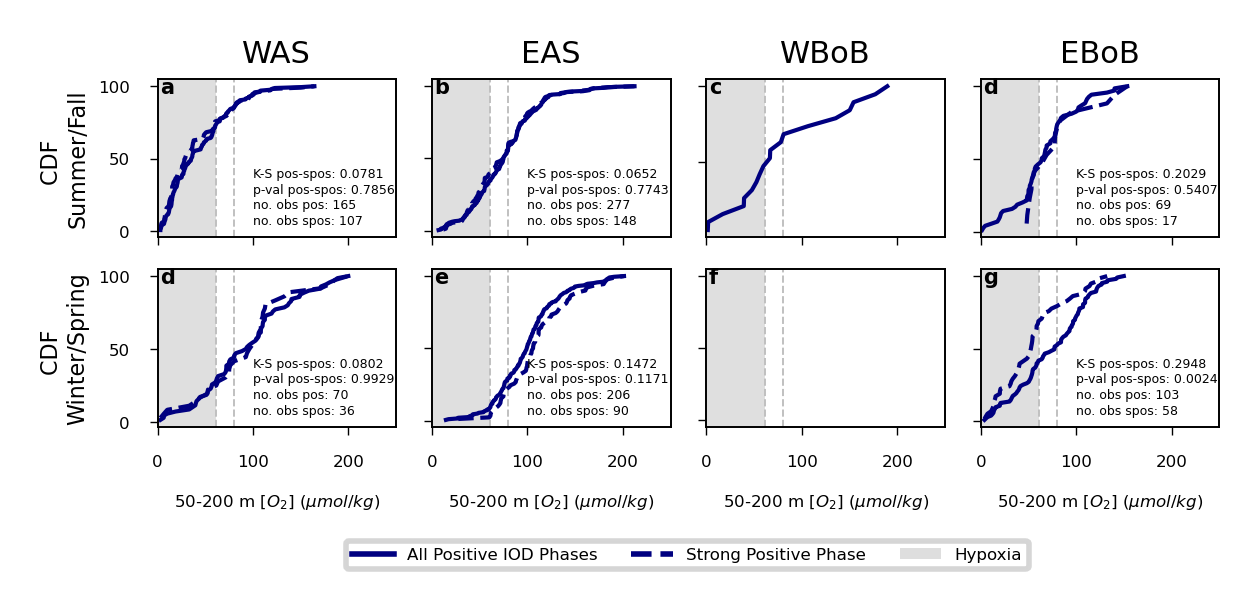

In [11]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# DMI
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
sposIODyears = list(np.array(ds_DMI.spos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

depth = '50_200'
Depth = '50-200'
############################################################################################################
# Western Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_wAS_' + depth]
lat = ds_WOD.lat_wAS
lon = ds_WOD.lon_wAS
t = ds_WOD.time_wAS

# positive IOD years -------------------------------------------# 
posIODdata_wAS,_,_,posIODtime_wAS,posIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wAS')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wAS,_,_,sposIODtime_wAS,sposIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wAS')

# negative IOD years -------------------------------------------# 
negIODdata_wAS,_,_,_,negIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_wAS,_,_,_,neuIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wAS')

############################################################################################################
# Eastern Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_eAS_' + depth]
lat = ds_WOD.lat_eAS
lon = ds_WOD.lon_eAS
t = ds_WOD.time_eAS

# positive IOD years -------------------------------------------# 
posIODdata_eAS,_,_,_,posIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eAS')

# strong positive IOD years -------------------------------------------# 
sposIODdata_eAS,_,_,_,sposIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eAS')

# negative IOD years -------------------------------------------# 
negIODdata_eAS,_,_,_,negIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_eAS,_,_,_,neuIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eAS')

############################################################################################################
# Western Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_wBoB_' + depth]
lat = ds_WOD.lat_wBoB
lon = ds_WOD.lon_wBoB
t = ds_WOD.time_wBoB

# positive IOD years -------------------------------------------# 
posIODdata_wBoB,_,_,_,posIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wBoB,_,_,_,sposIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wBoB')
# negative IOD years -------------------------------------------# 
negIODdata_wBoB,_,_,_,negIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_wBoB,_,_,_,neuIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wBoB')

############################################################################################################
# Eastern Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_eBoB_' + depth]
lat = ds_WOD.lat_eBoB
lon = ds_WOD.lon_eBoB
t = ds_WOD.time_eBoB

# positive IOD years -------------------------------------------# 
posIODdata_eBoB,_,_,_,posIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_eBoB,_,_,_,sposIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eBoB')
# negative IOD years -------------------------------------------# 
negIODdata_eBoB,_,_,_,negIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_eBoB,_,_,_,neuIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eBoB')

# Make Histograms 
# hatch_mask = min_mean > hyp_thresh
x = [1,2,3,4]

fig = plt.figure(figsize=(8.7 / 2.54, 1.5), dpi=400)

params = {'legend.fontsize': 3,
         'axes.labelsize': 3.5,
         'axes.titlesize': 5.5,
         'xtick.labelsize':3,
         'ytick.labelsize':3,
         'axes.linewidth':0.35,
         'xtick.major.width':0.25,
         'xtick.major.size':1.5,
         'ytick.major.width':0.25,
         'ytick.major.size':1.5}

pylab.rcParams.update(params)

text_fz = 4.5
sq_sz = 20
lfz = 3.75
width = 0.2
lw = 0.75

# clrs = ['darkgreen','darkorange','navy','darkorchid', 'darkgreen']
clrs = ['darkgreen','navy','darkorange','darkorchid', 'darkgreen']
labels = ['Positive IOD Phases','Strong Positive Phases']
letters = ['a','b','c','d','e','f','g','h']


regions = ['WAS','EAS','WBoB','EBoB']

####################################################################################################

data_wAS = [neuIODdata_wAS,posIODdata_wAS,negIODdata_wAS,sposIODdata_wAS]
data_eAS = [neuIODdata_eAS,posIODdata_eAS,negIODdata_eAS,sposIODdata_eAS]
data_wBoB = [neuIODdata_wBoB,posIODdata_wBoB,negIODdata_wBoB,sposIODdata_wBoB]
data_eBoB = [neuIODdata_eBoB,posIODdata_eBoB,negIODdata_eBoB,sposIODdata_eBoB]

time_data_wAS = [neuIODmon_wAS,posIODmon_wAS,negIODmon_wAS,sposIODmon_wAS]
time_data_eAS = [neuIODmon_eAS,posIODmon_eAS,negIODmon_eAS,sposIODmon_eAS]
time_data_wBoB = [neuIODmon_wBoB,posIODmon_wBoB,negIODmon_wBoB,sposIODmon_wBoB]
time_data_eBoB = [neuIODmon_eBoB,posIODmon_eBoB,negIODmon_eBoB,sposIODmon_eBoB]



cnt = 1
for pp in range(4):

    if pp==0:
        sdata = data_wAS[0]
        pdata = data_wAS[1]
        ndata = data_wAS[2]
        spdata = data_wAS[3]
        
        stdata = time_data_wAS[0]
        ptdata = time_data_wAS[1]
        ntdata = time_data_wAS[2]
        sptdata = time_data_wAS[3]

    elif pp==1:
        sdata = data_eAS[0]
        pdata = data_eAS[1]
        ndata = data_eAS[2]
        spdata = data_eAS[3]
        
        stdata = time_data_eAS[0]
        ptdata = time_data_eAS[1]
        ntdata = time_data_eAS[2]
        sptdata = time_data_eAS[3]

    elif pp==2:
        sdata = data_wBoB[0]
        pdata = data_wBoB[1]
        ndata = data_wBoB[2]
        spdata = data_wBoB[3]
        
        stdata = time_data_wBoB[0]
        ptdata = time_data_wBoB[1]
        ntdata = time_data_wBoB[2]
        sptdata = time_data_wBoB[3]

    else:
        sdata = data_eBoB[0]
        pdata = data_eBoB[1]
        ndata = data_eBoB[2]
        spdata = data_eBoB[3]
        
        stdata = time_data_eBoB[0]
        ptdata = time_data_eBoB[1]
        ntdata = time_data_eBoB[2]
        sptdata = time_data_eBoB[3]

    # O2
    x1 = sdata[~np.isnan(sdata)]
    x2 = pdata[~np.isnan(pdata)]
    x3 = ndata[~np.isnan(ndata)]
    x4 = spdata[~np.isnan(spdata)]

    x1t = stdata[~np.isnan(sdata)]
    x2t = ptdata[~np.isnan(pdata)]
    x3t = ntdata[~np.isnan(ndata)]
    x4t = sptdata[~np.isnan(spdata)]

    # get seasonal indicies
    ind_sf = (x1t == 6) | (x1t == 7) | (x1t == 8) | (x1t == 9) | (x1t == 10) | (x1t == 11)
    ind_ws = (x1t == 12) | (x1t == 1) | (x1t == 2) | (x1t == 3) | (x1t == 4) | (x1t ==5)

    x1_sf = x1[ind_sf]
    x1_ws = x1[ind_ws]

    ind_sf = (x2t == 6) | (x2t == 7) | (x2t == 8) | (x2t == 9) | (x2t == 10) | (x2t == 11)
    ind_ws = (x2t == 12) | (x2t == 1) | (x2t == 2) | (x2t == 3) | (x2t == 4) | (x2t ==5)

    x2_sf = x2[ind_sf]
    x2_ws = x2[ind_ws]

    ind_sf = (x3t == 6) | (x3t == 7) | (x3t == 8) | (x3t == 9) | (x3t == 10) | (x3t == 11)
    ind_ws = (x3t == 12) | (x3t == 1) | (x3t == 2) | (x3t == 3) | (x3t == 4) | (x3t ==5)

    x3_sf = x3[ind_sf]
    x3_ws = x3[ind_ws]
    
    ind_sf = (x4t == 6) | (x4t == 7) | (x4t == 8) | (x4t == 9) | (x4t == 10) | (x4t == 11)
    ind_ws = (x4t == 12) | (x4t == 1) | (x4t == 2) | (x4t == 3) | (x4t == 4) | (x4t ==5)

    x4_sf = x4[ind_sf]
    x4_ws = x4[ind_ws]

    
    # sort
    x1_sf = np.sort(x1_sf)
    x2_sf = np.sort(x2_sf)
    x3_sf = np.sort(x3_sf)
    x4_sf = np.sort(x4_sf)
    
    x1_ws = np.sort(x1_ws)
    x2_ws = np.sort(x2_ws)
    x3_ws = np.sort(x3_ws)
    x4_ws = np.sort(x4_ws)
    
    # ks test
    if (len(x1_sf)>0) & (len(x2_sf)>0):
        pos_all_ks_sf = stats.ks_2samp(x1_sf,x2_sf)
    if (len(x1_sf)>0) & (len(x3_sf)>0):    
        neg_all_ks_sf = stats.ks_2samp(x1_sf,x3_sf)
    if (len(x2_sf)>0) & (len(x3_sf)>0):
        pos_neg_ks_sf = stats.ks_2samp(x2_sf,x3_sf)
    if (len(x2_sf)>0) & (len(x4_sf)>0):
        pos_spos_ks_sf = stats.ks_2samp(x2_sf,x4_sf)

    if (len(x1_ws)>0) & (len(x2_ws)>0):
        pos_all_ks_ws = stats.ks_2samp(x1_ws,x2_ws)
    if (len(x1_ws)>0) & (len(x3_ws)>0):
        neg_all_ks_ws = stats.ks_2samp(x1_ws,x3_ws)
    if (len(x2_ws)>0) & (len(x3_ws)>0):
        pos_neg_ks_ws = stats.ks_2samp(x2_ws,x3_ws)
    if (len(x2_ws)>0) & (len(x4_ws)>0):
        pos_spos_ks_ws = stats.ks_2samp(x2_ws,x4_ws)

    # summer/fall --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', linewidth = 0)
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)
    
   
    # positive IOD
    tmp = np.sort(x2_sf)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    plt.plot(tmp,cdf, linewidth = lw, color = clrs[1])
    
    # strong positive IOD 
    tmp = np.sort(x4_sf)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    plt.plot(tmp,cdf, linewidth = lw, color = clrs[1], linestyle = '--')

    
    if cnt == 1:
        ax.set_ylabel('CDF \nSummer/Fall', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
        
    ax.set_title(regions[pp], pad = 3)
    ax.set_xticklabels([])
        
    ax.set_xlim([0,250])
    add_letter(ax, letters[cnt-1], x = 0.01,y=0.91, fontsize = lfz)
    if (len(x2_sf)>1) & (len(x4_sf)>1):
        add_text(ax, 'K-S pos-spos: ' + str(np.round(pos_spos_ks_sf[0],4)), x = 0.4,y=0.38, fontsize = 2.25)
        add_text(ax, 'p-val pos-spos: ' + str(np.round(pos_spos_ks_sf[1],4)), x = 0.4,y=0.28, fontsize = 2.25)
        add_text(ax, 'no. obs pos: ' + str(len(x2_sf)), x = 0.4,y=0.18, fontsize = 2.25)
        add_text(ax, 'no. obs spos: ' + str(len(x4_sf)), x = 0.4,y=0.08, fontsize = 2.25)

    

    # winter/spring --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt + 4)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', label = 'Hypoxia', linewidth = 0)
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)

    # positive IOD
    tmp = np.sort(x2_ws)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    ax.plot(tmp,cdf, linewidth = lw, color = clrs[1], label = 'All Positive IOD Phases')
   
    # strong positive IOD 
    tmp = np.sort(x4_ws)
    cdf = (np.arange(len(tmp))+1)/len(tmp)*100
    
    ax.plot(tmp,cdf, linewidth = lw, color = clrs[1], linestyle = '--',label = 'Strong Positive Phase')
    
    ax.set_xlim([0,250])
    if cnt == 1:
        ax.set_ylabel('CDF \nWinter/Spring', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel(Depth + ' m [$O_2$] ($\mu mol/ kg$)', fontsize = 3)
    add_letter(ax, letters[cnt+2], x = 0.01,y=0.91, fontsize = lfz)
    if (len(x2_ws)>1) & (len(x4_ws)>1):
        add_text(ax, 'K-S pos-spos: ' + str(np.round(pos_spos_ks_ws[0],4)), x = 0.4,y=0.38, fontsize = 2.25)
        add_text(ax, 'p-val pos-spos: ' + str(np.round(pos_spos_ks_ws[1],4)), x = 0.4,y=0.28, fontsize = 2.25)
        add_text(ax, 'no. obs pos: ' + str(len(x2_ws)), x = 0.4,y=0.18, fontsize = 2.25)
        add_text(ax, 'no. obs spos: ' + str(len(x4_ws)), x = 0.4,y=0.08, fontsize = 2.25)

    cnt += 1

leg = ax.legend(loc='lower center', bbox_to_anchor=(-1.23, -.95),
          ncol=5, handlelength = 2.5)

for line in leg.get_lines():
    line.set_linewidth(1.0)

plt.subplots_adjust(wspace = 0.15, bottom = 0.3)

plt.savefig(figpath + 'Fig_S16_cdfs_sposiods.pdf', format='pdf', dpi = 400)



# S17 - PDFs

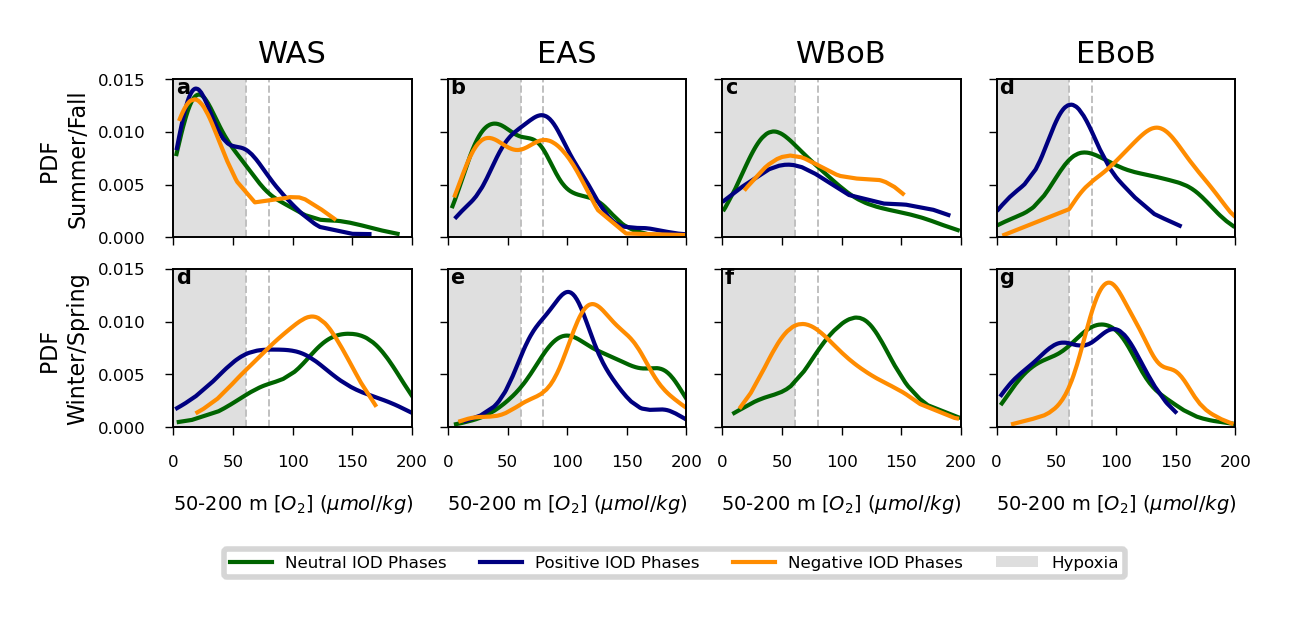

In [10]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# DMI
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
sposIODyears = list(np.array(ds_DMI.spos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

depth = '50_200'
Depth = '50-200'
############################################################################################################
# Western Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_wAS_' + depth]
lat = ds_WOD.lat_wAS
lon = ds_WOD.lon_wAS
t = ds_WOD.time_wAS

# positive IOD years -------------------------------------------# 
posIODdata_wAS,_,_,posIODtime_wAS,posIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wAS')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wAS,_,_,sposIODtime_wAS,sposIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wAS')

# negative IOD years -------------------------------------------# 
negIODdata_wAS,_,_,_,negIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_wAS,_,_,_,neuIODmon_wAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wAS')

############################################################################################################
# Eastern Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_eAS_' + depth]
lat = ds_WOD.lat_eAS
lon = ds_WOD.lon_eAS
t = ds_WOD.time_eAS

# positive IOD years -------------------------------------------# 
posIODdata_eAS,_,_,_,posIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eAS')

# strong positive IOD years -------------------------------------------# 
sposIODdata_eAS,_,_,_,sposIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eAS')

# negative IOD years -------------------------------------------# 
negIODdata_eAS,_,_,_,negIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_eAS,_,_,_,neuIODmon_eAS,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eAS')

############################################################################################################
# Western Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_wBoB_' + depth]
lat = ds_WOD.lat_wBoB
lon = ds_WOD.lon_wBoB
t = ds_WOD.time_wBoB

# positive IOD years -------------------------------------------# 
posIODdata_wBoB,_,_,_,posIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_wBoB,_,_,_,sposIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'wBoB')
# negative IOD years -------------------------------------------# 
negIODdata_wBoB,_,_,_,negIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_wBoB,_,_,_,neuIODmon_wBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wBoB')

############################################################################################################
# Eastern Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_eBoB_' + depth]
lat = ds_WOD.lat_eBoB
lon = ds_WOD.lon_eBoB
t = ds_WOD.time_eBoB

# positive IOD years -------------------------------------------# 
posIODdata_eBoB,_,_,_,posIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eBoB')
# strong positive IOD years -------------------------------------------# 
sposIODdata_eBoB,_,_,_,sposIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             sposIODyears, region = 'eBoB')
# negative IOD years -------------------------------------------# 
negIODdata_eBoB,_,_,_,negIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_eBoB,_,_,_,neuIODmon_eBoB,_ = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eBoB')

# Make Histograms 
# hatch_mask = min_mean > hyp_thresh
x = [1,2,3,4]

fig = plt.figure(figsize=(8.7 / 2.54, 1.5), dpi=400)

params = {'legend.fontsize': 3,
         'axes.labelsize': 3.5,
         'axes.titlesize': 5.5,
         'xtick.labelsize':3,
         'ytick.labelsize':3,
         'axes.linewidth':0.35,
         'xtick.major.width':0.25,
         'xtick.major.size':1.5,
         'ytick.major.width':0.25,
         'ytick.major.size':1.5}
pylab.rcParams.update(params)

text_fz = 4.5
sq_sz = 20
lfz = 3.75
width = 0.2
lw = 0.75

# clrs = ['darkgreen','darkorange','navy','darkorchid', 'darkgreen']
clrs = ['darkgreen','navy','darkorange','darkorchid', 'darkgreen']
labels = ['Neutral IOD Phases','Positive IOD Phases','Negative IOD Phases','Hypoxia']
letters = ['a','b','c','d','e','f','g','h']

regions = ['WAS','EAS','WBoB','EBoB']

####################################################################################################

data_wAS = [neuIODdata_wAS,posIODdata_wAS,negIODdata_wAS,sposIODdata_wAS]
data_eAS = [neuIODdata_eAS,posIODdata_eAS,negIODdata_eAS,sposIODdata_eAS]
data_wBoB = [neuIODdata_wBoB,posIODdata_wBoB,negIODdata_wBoB,sposIODdata_wBoB]
data_eBoB = [neuIODdata_eBoB,posIODdata_eBoB,negIODdata_eBoB,sposIODdata_eBoB]

time_data_wAS = [neuIODmon_wAS,posIODmon_wAS,negIODmon_wAS,sposIODmon_wAS]
time_data_eAS = [neuIODmon_eAS,posIODmon_eAS,negIODmon_eAS,sposIODmon_eAS]
time_data_wBoB = [neuIODmon_wBoB,posIODmon_wBoB,negIODmon_wBoB,sposIODmon_wBoB]
time_data_eBoB = [neuIODmon_eBoB,posIODmon_eBoB,negIODmon_eBoB,sposIODmon_eBoB]

cnt = 1
for pp in range(4):

    if pp==0:
        sdata = data_wAS[0]
        pdata = data_wAS[1]
        ndata = data_wAS[2]
        spdata = data_wAS[3]
        
        stdata = time_data_wAS[0]
        ptdata = time_data_wAS[1]
        ntdata = time_data_wAS[2]
        sptdata = time_data_wAS[3]

    elif pp==1:
        sdata = data_eAS[0]
        pdata = data_eAS[1]
        ndata = data_eAS[2]
        spdata = data_eAS[3]
        
        stdata = time_data_eAS[0]
        ptdata = time_data_eAS[1]
        ntdata = time_data_eAS[2]
        sptdata = time_data_eAS[3]

    elif pp==2:
        sdata = data_wBoB[0]
        pdata = data_wBoB[1]
        ndata = data_wBoB[2]
        spdata = data_wBoB[3]
        
        stdata = time_data_wBoB[0]
        ptdata = time_data_wBoB[1]
        ntdata = time_data_wBoB[2]
        sptdata = time_data_wBoB[3]

    else:
        sdata = data_eBoB[0]
        pdata = data_eBoB[1]
        ndata = data_eBoB[2]
        spdata = data_eBoB[3]
        
        stdata = time_data_eBoB[0]
        ptdata = time_data_eBoB[1]
        ntdata = time_data_eBoB[2]
        sptdata = time_data_eBoB[3]

    # O2
    x1 = sdata[~np.isnan(sdata)]
    x2 = pdata[~np.isnan(pdata)]
    x3 = ndata[~np.isnan(ndata)]
    x4 = spdata[~np.isnan(spdata)]

    x1t = stdata[~np.isnan(sdata)]
    x2t = ptdata[~np.isnan(pdata)]
    x3t = ntdata[~np.isnan(ndata)]
    x4t = sptdata[~np.isnan(spdata)]

    # get seasonal indicies
    ind_sf = (x1t == 6) | (x1t == 7) | (x1t == 8) | (x1t == 9) | (x1t == 10) | (x1t == 11)
    ind_ws = (x1t == 12) | (x1t == 1) | (x1t == 2) | (x1t == 3) | (x1t == 4) | (x1t ==5)

    x1_sf = x1[ind_sf]
    x1_ws = x1[ind_ws]

    ind_sf = (x2t == 6) | (x2t == 7) | (x2t == 8) | (x2t == 9) | (x2t == 10) | (x2t == 11)
    ind_ws = (x2t == 12) | (x2t == 1) | (x2t == 2) | (x2t == 3) | (x2t == 4) | (x2t ==5)

    x2_sf = x2[ind_sf]
    x2_ws = x2[ind_ws]

    ind_sf = (x3t == 6) | (x3t == 7) | (x3t == 8) | (x3t == 9) | (x3t == 10) | (x3t == 11)
    ind_ws = (x3t == 12) | (x3t == 1) | (x3t == 2) | (x3t == 3) | (x3t == 4) | (x3t ==5)

    x3_sf = x3[ind_sf]
    x3_ws = x3[ind_ws]
    
    ind_sf = (x4t == 6) | (x4t == 7) | (x4t == 8) | (x4t == 9) | (x4t == 10) | (x4t == 11)
    ind_ws = (x4t == 12) | (x4t == 1) | (x4t == 2) | (x4t == 3) | (x4t == 4) | (x4t ==5)

    x4_sf = x4[ind_sf]
    x4_ws = x4[ind_ws]

    # summer/fall --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', linewidth = 0)
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)
    
    
    # seasonal 
    tmp = np.sort(x1_sf)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[0])
    
    # positive IOD
    tmp = np.sort(x2_sf)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[1])
    
    # negative IOD
    tmp = np.sort(x3_sf)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[2])

    
    if cnt == 1:
        ax.set_ylabel('PDF \nSummer/Fall', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
        
    ax.set_title(regions[pp], pad = 3)
    ax.set_xticklabels([])
        
    ax.set_xlim([0,200])
    ax.set_ylim([0,0.015])
    add_letter(ax, letters[cnt-1], x = 0.01,y=0.91, fontsize = lfz)

    # winter/spring --------------------------------------------------------------- #
    ax = fig.add_subplot(2,4,cnt + 4)
    ax.axvspan(-100, hyp_thresh, alpha=0.5, color='silver', linewidth = 0,label = labels[3])
    ax.axvline(x = hyp_thresh,color = 'silver',linestyle = '--', linewidth = 0.35)
    ax.axvline(x = 80,color = 'silver',linestyle = '--', linewidth = 0.35)

        # seasonal 
    tmp = np.sort(x1_ws)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[0], label = labels[0])
    
    # positive IOD
    tmp = np.sort(x2_ws)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[1], label = labels[1])
    
    # negative IOD
    tmp = np.sort(x3_ws)
    if len(tmp)>1:
        kernel = stats.gaussian_kde(tmp)
        plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[2], label = labels[2])
    
#     # strong positive IOD 
#     tmp = np.sort(x4_ws)
#     if len(tmp)>1:
#         kernel = stats.gaussian_kde(tmp)
#         plt.plot(tmp,kernel(tmp), linewidth = lw, color = clrs[1], linestyle = '--')
        
    ax.set_xlim([0,200])
    ax.set_ylim([0,0.015])
    if cnt == 1:
        ax.set_ylabel('PDF \nWinter/Spring', fontsize = 4,labelpad = 1.5)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel(Depth + ' m [$O_2$] ($\mu mol/ kg$)')
    add_letter(ax, letters[cnt+2], x = 0.01,y=0.91, fontsize = lfz)
    
    cnt += 1

ax.legend(loc='lower center', bbox_to_anchor=(-1.35, -1),
          ncol=5, handlelength = 2.5)

plt.subplots_adjust(wspace = 0.15, bottom = 0.3)

plt.savefig(figpath + 'Fig_S17_pdfs.pdf', format='pdf', dpi = 400)


# S18 - SLA Correlations

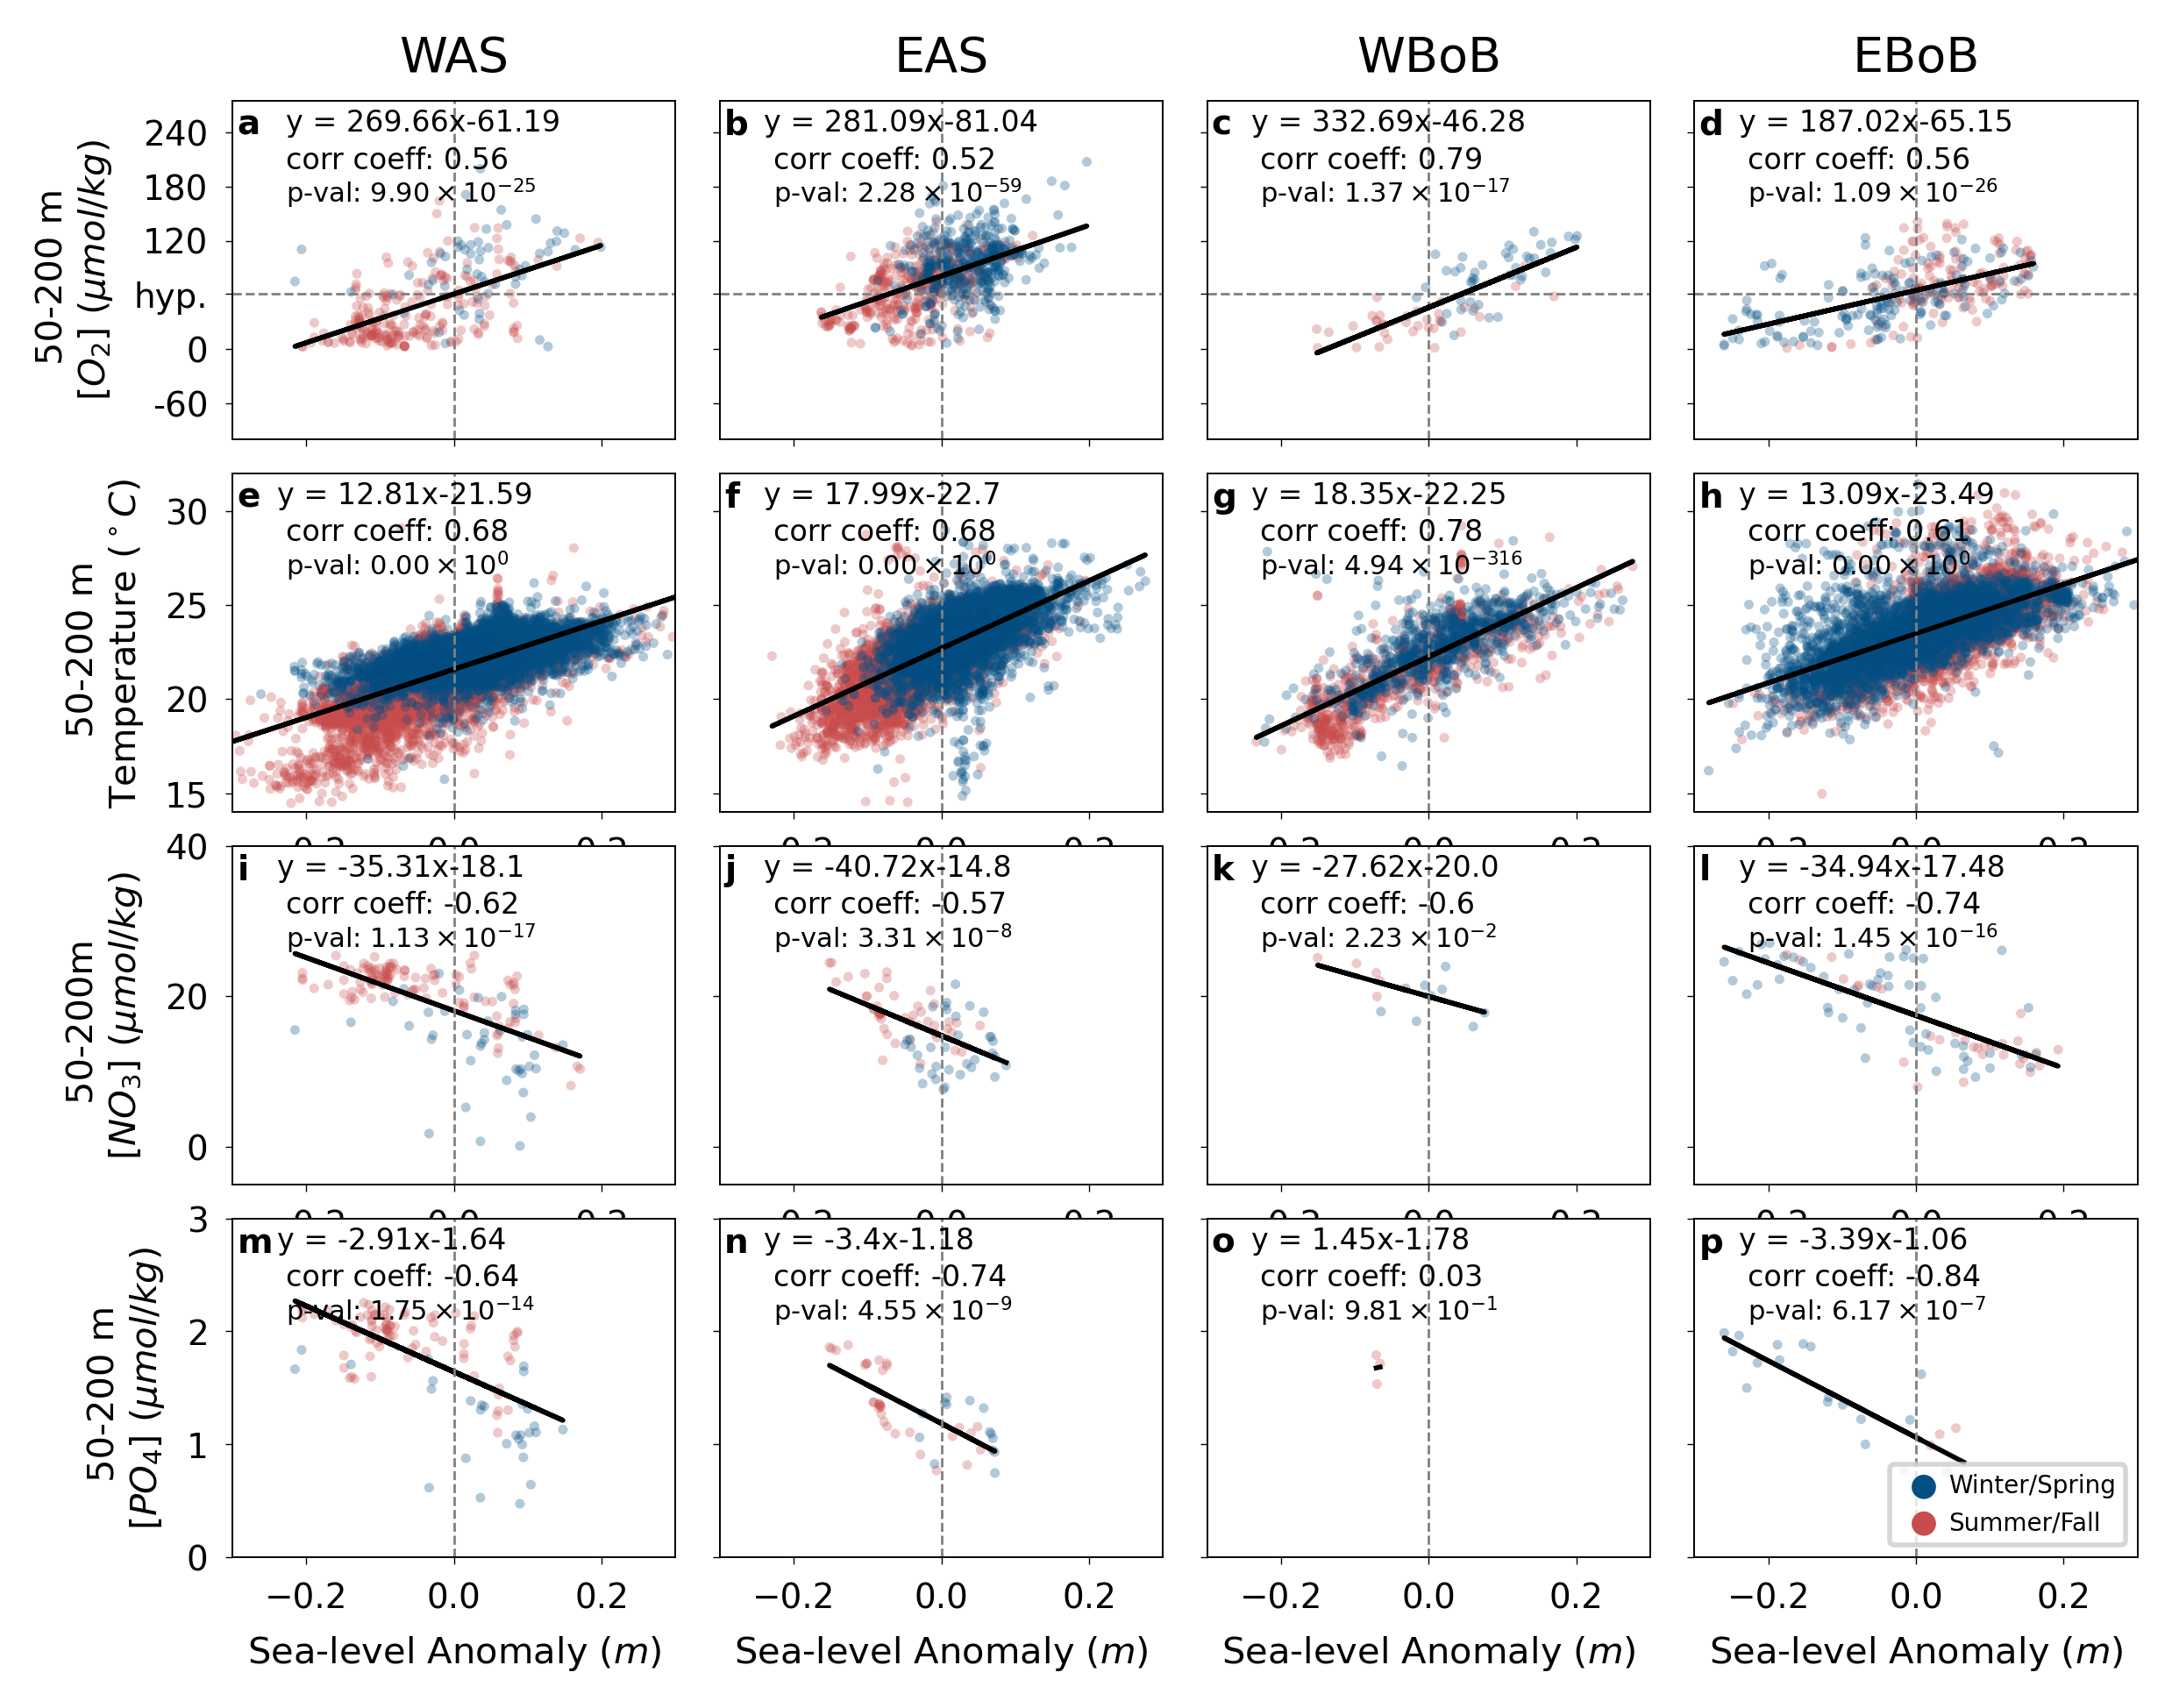

In [12]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# SLA
ds_SLA = xr.open_dataset('../data_processing/6_Regridding/sla_to_wod.nc')

depth = '50_200'
Depth = '50-200'
############################################################################
doxy_wAS = ds_WOD['doxy_wAS_' + depth]
doxy_eAS = ds_WOD['doxy_eAS_' + depth]
doxy_wBoB = ds_WOD['doxy_wBoB_' + depth]
doxy_eBoB = ds_WOD['doxy_eBoB_' + depth]

sla_wAS = ds_SLA['sla_wAS']
sla_eAS = ds_SLA['sla_eAS']
sla_wBoB = ds_SLA['sla_wBoB']
sla_eBoB = ds_SLA['sla_eBoB']

seas_wAS = ds_WOD['seas_wAS']
seas_eAS = ds_WOD['seas_eAS']
seas_wBoB = ds_WOD['seas_wBoB']
seas_eBoB = ds_WOD['seas_eBoB']

temp_wAS = ds_WOD['temp_wAS_' + depth]
temp_eAS = ds_WOD['temp_eAS_' + depth]
temp_wBoB = ds_WOD['temp_wBoB_' + depth]
temp_eBoB = ds_WOD['temp_eBoB_' + depth]

nitrate_wAS = ds_WOD['nitrate_wAS_' + depth]
nitrate_eAS = ds_WOD['nitrate_eAS_' + depth]
nitrate_wBoB = ds_WOD['nitrate_wBoB_' + depth]
nitrate_eBoB = ds_WOD['nitrate_eBoB_' + depth]

phosphate_wAS = ds_WOD['phosphate_wAS_' + depth]
phosphate_eAS = ds_WOD['phosphate_eAS_' + depth]
phosphate_wBoB = ds_WOD['phosphate_wBoB_' + depth]
phosphate_eBoB = ds_WOD['phosphate_eBoB_' + depth]
##############################################################
fig = plt.figure(figsize=(17.8 / 2.54,5.5),dpi=400)


regions = ['WAS','EAS','WBoB','EBoB']
sz = 4
fsz = 6
lfz = 7
lw = 1
alpha = .3


xlim = [-0.3,0.3]
ylim = [-100,275]

cmap = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])
s_clr = '#c94c4c'
w_clr = '#034f84'
piod_clr = 'darkgreen'
niod_clr = 'purple'

params = {'legend.fontsize': 5,
         'axes.labelsize': 7.5,
         'axes.titlesize': 10,
         'xtick.labelsize':7,
         'ytick.labelsize':7}

pylab.rcParams.update(params)

##############################################################

ax = fig.add_subplot(441)
var1 = sla_wAS
var2 = doxy_wAS
seas = seas_wAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[0])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([-60,0,'hyp.',120,180,240])
ax.set_ylabel(Depth + ' m \n[$O_2$] ($\mu mol/ kg$)')
add_letter(ax, 'a', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.12,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(442)
var1 = sla_eAS
var2 = doxy_eAS
seas = seas_eAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[1])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])

add_letter(ax, 'b', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(443)
var1 = sla_wBoB
var2 = doxy_wBoB
seas = seas_wBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[2])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'c', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(444)
var1 = sla_eBoB
var2 = doxy_eBoB
seas = seas_eBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'd', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)


#####################################################################
ylim = [14,32]

ax = fig.add_subplot(445)
var1 = sla_wAS
var2 = temp_wAS
seas = seas_wAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
# ax.set_yticklabels([-60,0,'hyp.',120,180,240])
ax.set_ylabel(Depth + ' m \nTemperature ($^\circ C$)')
add_letter(ax, 'e', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)



ax = fig.add_subplot(446)
var1 = sla_eAS
var2 = temp_eAS
seas = seas_eAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'f', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)


ax = fig.add_subplot(447)
var1 = sla_wBoB
var2 = temp_wBoB
seas = seas_wBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'g', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(448)
var1 = sla_eBoB
var2 = temp_eBoB
seas = seas_eBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'h', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

#####################################################################
ylim = [-5,40]

ax = fig.add_subplot(449)
var1 = sla_wAS
var2 = nitrate_wAS
seas = seas_wAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
# ax.set_yticklabels([-60,0,'hyp.',120,180,240])
ax.set_ylabel(Depth + 'm \n[$NO_3$] ($\mu mol/ kg$)')
add_letter(ax, 'i', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)



ax = fig.add_subplot(4,4,10)
var1 = sla_eAS
var2 = nitrate_eAS
seas = seas_eAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'j', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)


ax = fig.add_subplot(4,4,11)
var1 = sla_wBoB
var2 = nitrate_wBoB
seas = seas_wBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'k', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(4,4,12)
var1 = sla_eBoB
var2 = nitrate_eBoB
seas = seas_eBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'l', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)



#####################################################################
ylim = [0,3]

ax = fig.add_subplot(4,4,13)
var1 = sla_wAS
var2 = phosphate_wAS
seas = seas_wAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
# ax.set_yticklabels([-60,0,'hyp.',120,180,240])
ax.set_ylabel(Depth + ' m \n[$PO_4$] ($\mu mol/ kg$)')
ax.set_xlabel('Sea-level Anomaly ($m$)')
add_letter(ax, 'm', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)



ax = fig.add_subplot(4,4,14)
var1 = sla_eAS
var2 = phosphate_eAS
seas = seas_eAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
ax.set_xlabel('Sea-level Anomaly ($m$)')
add_letter(ax, 'n', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)


ax = fig.add_subplot(4,4,15)
var1 = sla_wBoB
var2 = phosphate_wBoB
seas = seas_wBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
ax.set_xlabel('Sea-level Anomaly ($m$)')
add_letter(ax, 'o', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(4,4,16)
var1 = sla_eBoB
var2 = phosphate_eBoB
seas = seas_eBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
ax.set_xlabel('Sea-level Anomaly ($m$)')
add_letter(ax, 'p', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)


ax.scatter(np.nan,np.nan,c = w_clr, s= sz, edgecolor = 'none', label = 'Winter/Spring')
ax.scatter(np.nan,np.nan,c = s_clr, s= sz, edgecolor = 'none', label = 'Summer/Fall')
# ax.axhline(y = -1,color = 'gray',linestyle = '--', linewidth = 0.5, label = 'hypoxia')
plt.legend(loc = 'lower right', handletextpad = 0.001, markerscale = 2.5)

plt.subplots_adjust(wspace = 0.1,hspace = 0.1)

plt.savefig(figpath + 'Fig_S18_sla_corr_o2_temp_nit_phos.pdf', format='pdf', dpi = 400)


# S19
- Temperature and Oxygen Correlations

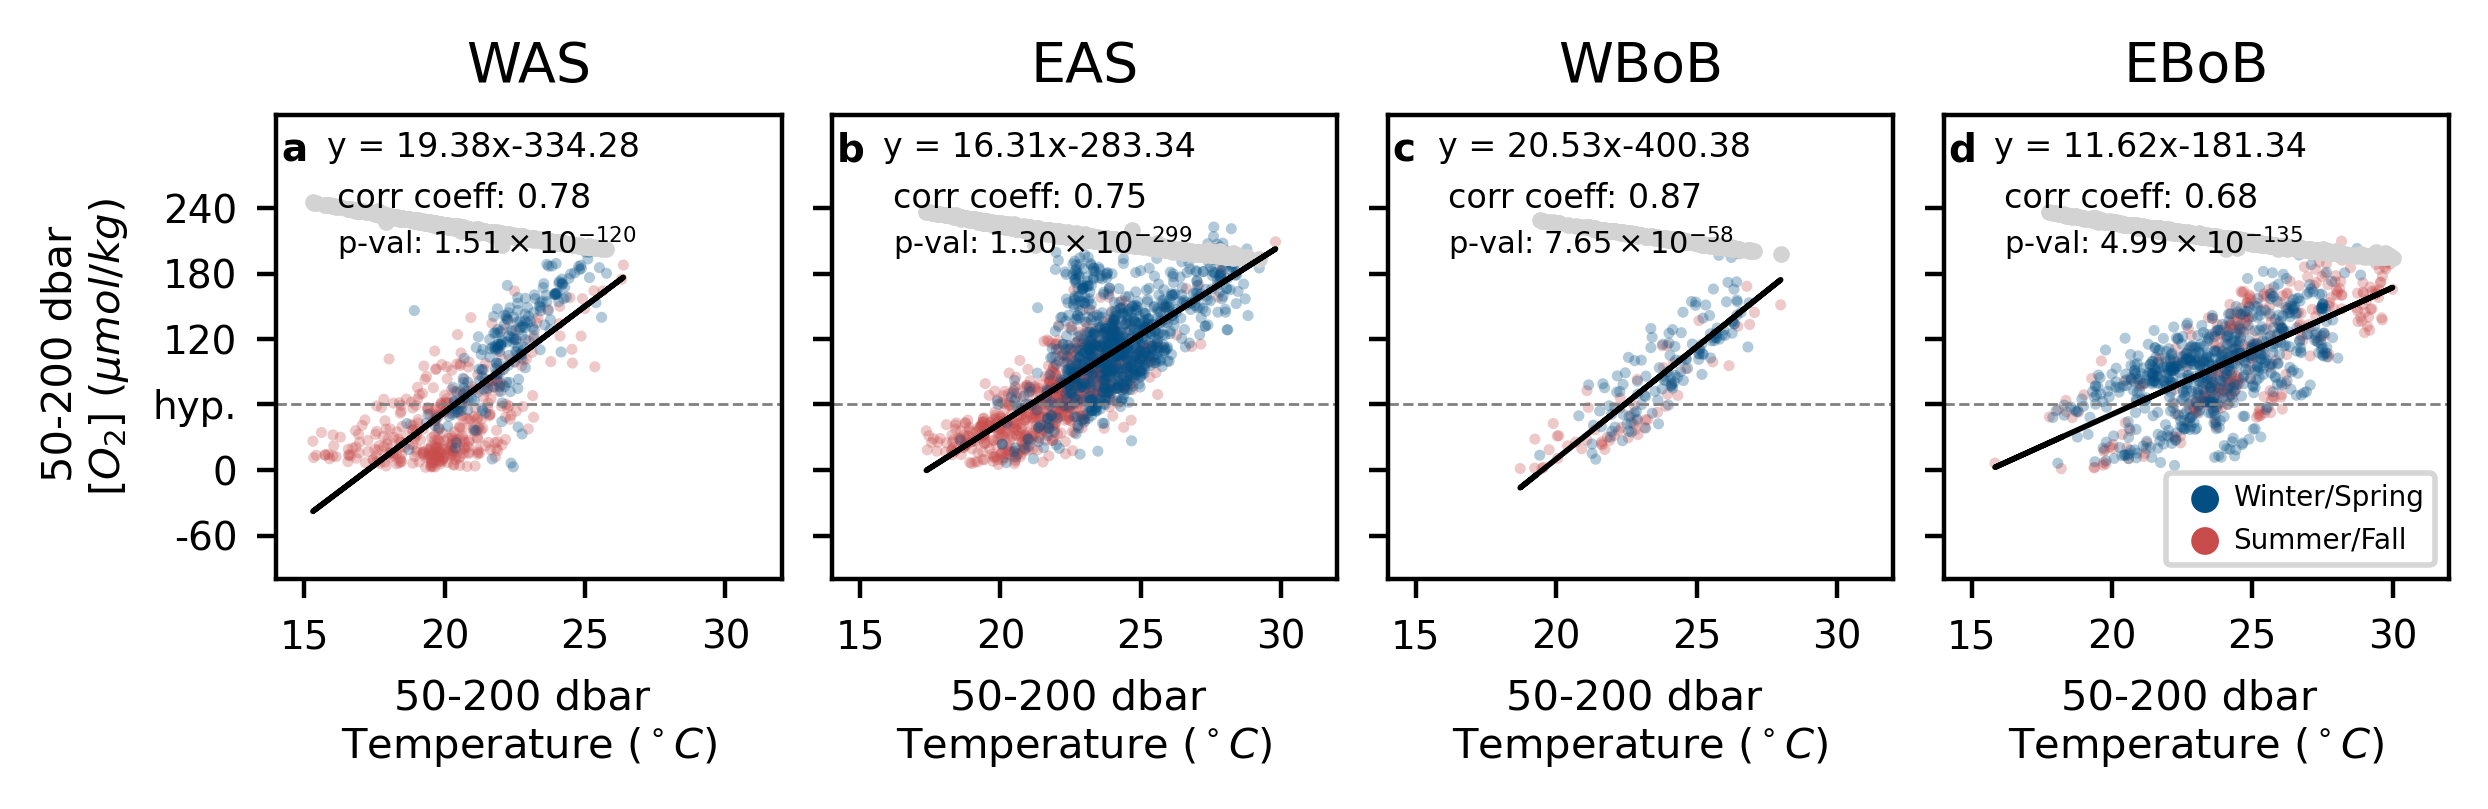

In [3]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# SLA
ds_SLA = xr.open_dataset('../data_processing/6_Regridding/sla_to_wod.nc')

depth = '50_200'
Depth = '50-200'
############################################################################
doxy_wAS = ds_WOD['doxy_wAS_' + depth]
doxy_eAS = ds_WOD['doxy_eAS_' + depth]
doxy_wBoB = ds_WOD['doxy_wBoB_' + depth]
doxy_eBoB = ds_WOD['doxy_eBoB_' + depth]

temp_wAS = ds_WOD['temp_wAS_' + depth]
temp_eAS = ds_WOD['temp_eAS_' + depth]
temp_wBoB = ds_WOD['temp_wBoB_' + depth]
temp_eBoB = ds_WOD['temp_eBoB_' + depth]

sla_wAS = ds_SLA['sla_wAS']
sla_eAS = ds_SLA['sla_eAS']
sla_wBoB = ds_SLA['sla_wBoB']
sla_eBoB = ds_SLA['sla_eBoB']

seas_wAS = ds_WOD['seas_wAS']
seas_eAS = ds_WOD['seas_eAS']
seas_wBoB = ds_WOD['seas_wBoB']
seas_eBoB = ds_WOD['seas_eBoB']

O2_sat_wAS = ds_WOD['sol_wAS_' + depth]
O2_sat_eAS = ds_WOD['sol_eAS_' + depth]
O2_sat_wBoB = ds_WOD['sol_wBoB_' + depth]
O2_sat_eBoB = ds_WOD['sol_eBoB_' + depth]

##############################################################
fig = plt.figure(figsize=(17.8 / 2.54,2),dpi=400)

sz = 4
fsz = 6
lfz = 7
lw = 1
alpha = .3


xlim = [14,32]
ylim = [-100,325]

regions = ['WAS','EAS','WBoB','EBoB']

cmap = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])
s_clr = '#c94c4c'
w_clr = '#034f84'
piod_clr = 'darkgreen'
niod_clr = 'purple'
sat_clr = 'lightgray'

params = {'legend.fontsize': 5,
         'axes.labelsize': 7.5,
         'axes.titlesize': 10,
         'xtick.labelsize':7,
         'ytick.labelsize':7}

pylab.rcParams.update(params)

##############################################################

ax = fig.add_subplot(141)
var1 = temp_wAS
var2 = doxy_wAS
var3 = O2_sat_wAS
seas = seas_wAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
var3 = var3[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.scatter(var1,var3,c = sat_clr,s= sz)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[0])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([-60,0,'hyp.',120,180,240])
ax.set_xlabel(Depth + ' dbar \nTemperature ($^\circ C$)')
ax.set_ylabel(Depth + ' dbar \n[$O_2$] ($\mu mol/ kg$)')
add_letter(ax, 'a', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(142)
var1 = temp_eAS
var2 = doxy_eAS
var3 = O2_sat_eAS
seas = seas_eAS

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
var3 = var3[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.scatter(var1,var3,c = sat_clr,s= sz)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[1])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(Depth + ' dbar \nTemperature ($^\circ C$)')
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'b', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(143)
var1 = temp_wBoB
var2 = doxy_wBoB
var3 = O2_sat_wBoB
seas = seas_wBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
var3 = var3[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.scatter(var1,var3,c = sat_clr,s= sz)
ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[2])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(Depth + ' dbar \nTemperature ($^\circ C$)')
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'c', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)

ax = fig.add_subplot(144)
var1 = temp_eBoB
var2 = doxy_eBoB
var3 = O2_sat_eBoB
seas = seas_eBoB

ind = np.isnan(var1) | np.isnan(var2)
var1 = var1[~ind]
var2 = var2[~ind]
var3 = var3[~ind]
seas = seas[~ind]

#s/f
ind = seas == 1
ax.scatter(var1[ind],var2[ind],c = s_clr, s= sz,alpha = alpha, edgecolor = 'none')
#w/s
ind = seas == 0
ax.scatter(var1[ind],var2[ind],c = w_clr, s= sz,alpha = alpha, edgecolor = 'none')

ax.scatter(var1,var3,c = sat_clr,s= sz)

ax.axhline(y = hyp_thresh,color = 'gray',linestyle = '--', linewidth = 0.5)
ax.axvline(x = 0,color = 'gray',linestyle = '--', linewidth = 0.5)

m, b, r, p_val,_ =stats.linregress(var1, var2)
ax.plot(var1, m*var1 + b, 'k', linewidth = lw)
ax.set_title(regions[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(Depth + ' dbar \nTemperature ($^\circ C$)')
ax.set_yticks([-60,0,61,120,180,240])
ax.set_yticklabels([])
add_letter(ax, 'd', x = 0.01,y=0.9, fontsize = lfz)
add_text(ax, 'y = ' + str(np.round(m,2)) + 'x-' + str(np.round(np.abs(b),2)), x = 0.1,y=0.91, fontsize = fsz)
add_text(ax, 'corr coeff: ' + str(np.round(r,2)), x = 0.12,y=0.8, fontsize = fsz)
add_text(ax, 'p-val: ' + r'${0:s}$'.format(as_si(p_val,2)), x = 0.12,y=0.7, fontsize = fsz-0.5)



ax.scatter(np.nan,np.nan,c = w_clr, s= sz, edgecolor = 'none', label = 'Winter/Spring')
ax.scatter(np.nan,np.nan,c = s_clr, s= sz, edgecolor = 'none', label = 'Summer/Fall')
plt.legend(loc = 'lower right', handletextpad = 0.001, markerscale = 2.5)

plt.subplots_adjust(wspace = 0.1, bottom = 0.3)

plt.savefig(figpath + 'Fig_S19_doxy_corr_temp_and_sol.pdf', format='pdf', dpi = 400)

# S20 - Locations of oxygen profiles used during IOD phases

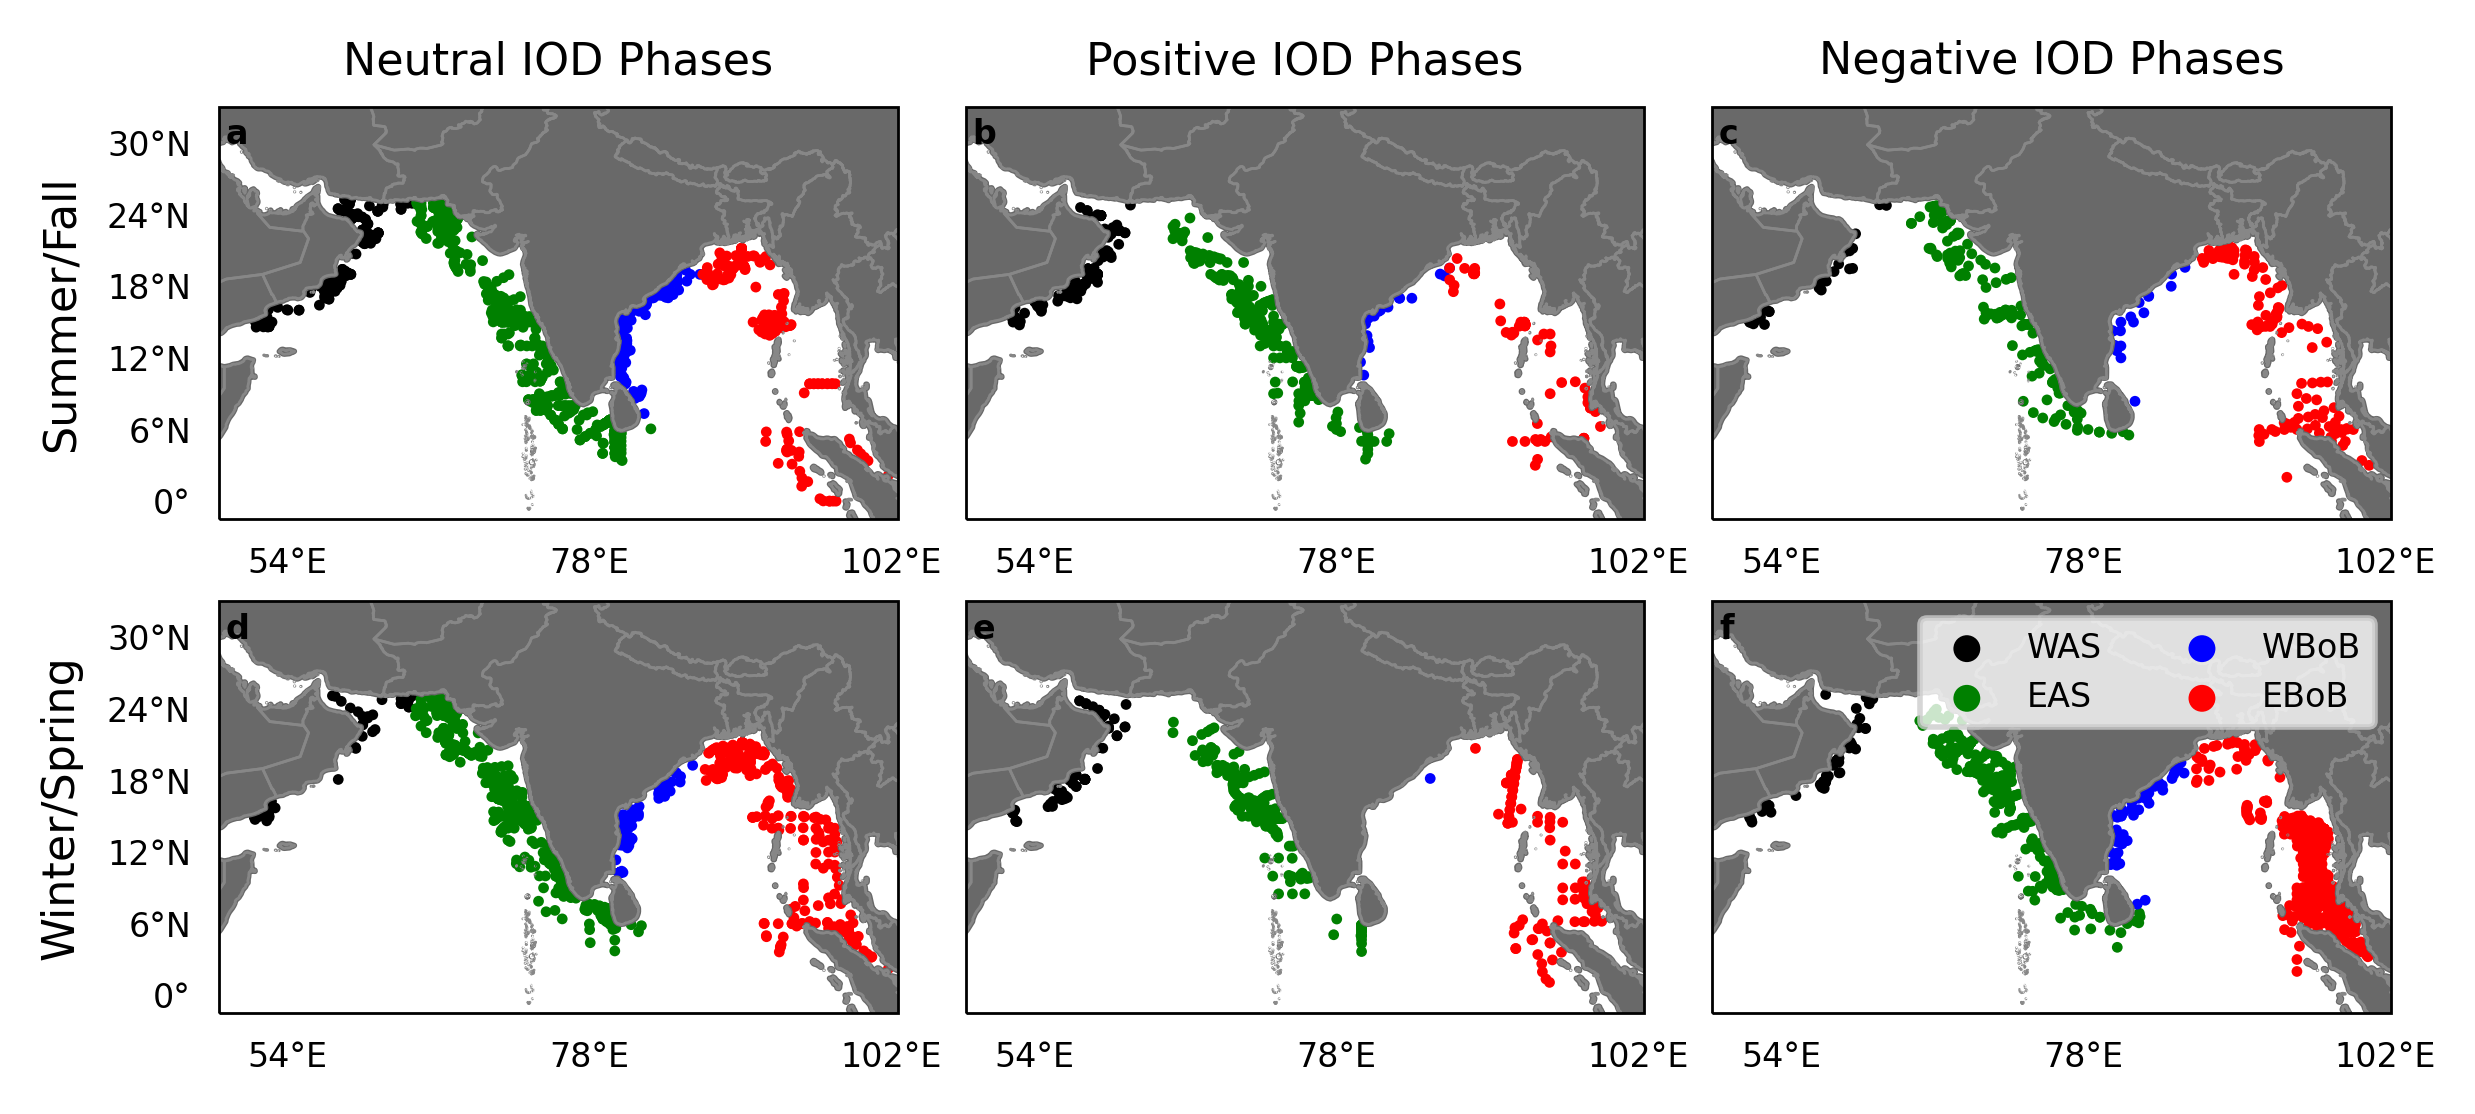

In [14]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# DMI
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
sposIODyears = list(np.array(ds_DMI.spos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

depth = '50_200'
Depth = '50-200'
############################################################################################################
# Western Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_wAS_' + depth]
lat = ds_WOD.lat_wAS
lon = ds_WOD.lon_wAS
t = ds_WOD.time_wAS

# positive IOD years -------------------------------------------# 
posIODdata_wAS,posIODlat_wAS,posIODlon_wAS,_,posIODmon_wAS,posIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wAS')

# negative IOD years -------------------------------------------# 
negIODdata_wAS,negIODlat_wAS,negIODlon_wAS,_,negIODmon_wAS,negIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_wAS,neuIODlat_wAS,neuIODlon_wAS,_,neuIODmon_wAS,neuIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wAS')

############################################################################################################
# Eastern Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_eAS_' + depth]
lat = ds_WOD.lat_eAS
lon = ds_WOD.lon_eAS
t = ds_WOD.time_eAS

# positive IOD years -------------------------------------------# 
posIODdata_eAS,posIODlat_eAS,posIODlon_eAS,_,posIODmon_eAS,posIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eAS')

# negative IOD years -------------------------------------------# 
negIODdata_eAS,negIODlat_eAS,negIODlon_eAS,_,negIODmon_eAS,negIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_eAS,neuIODlat_eAS,neuIODlon_eAS,_,neuIODmon_eAS,neuIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eAS')

############################################################################################################
# Western Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_wBoB_' + depth]
lat = ds_WOD.lat_wBoB
lon = ds_WOD.lon_wBoB
t = ds_WOD.time_wBoB

# positive IOD years -------------------------------------------# 
posIODdata_wBoB,posIODlat_wBoB,posIODlon_wBoB,_,posIODmon_wBoB,posIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wBoB')
# negative IOD years -------------------------------------------# 
negIODdata_wBoB,negIODlat_wBoB,negIODlon_wBoB,_,negIODmon_wBoB,negIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_wBoB,neuIODlat_wBoB,neuIODlon_wBoB,_,neuIODmon_wBoB,neuIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wBoB')

############################################################################################################
# Eastern Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_eBoB_' + depth]
lat = ds_WOD.lat_eBoB
lon = ds_WOD.lon_eBoB
t = ds_WOD.time_eBoB

# positive IOD years -------------------------------------------# 
posIODdata_eBoB,posIODlat_eBoB,posIODlon_eBoB,_,posIODmon_eBoB,posIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eBoB')
# negative IOD years -------------------------------------------# 
negIODdata_eBoB,negIODlat_eBoB,negIODlon_eBoB,_,negIODmon_eBoB,negIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_eBoB,neuIODlat_eBoB,neuIODlon_eBoB,_,neuIODmon_eBoB,neuIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eBoB')

fig = plt.figure(figsize=(17.8/2.54,3),dpi=400)

sz = 15
sq_sz = 60
fsz = 12
alpha = 0.25
lfz = 6

sp_clr = 'purple'
sat_clr = 'lightgrey'

params = {'legend.fontsize': 6,
         'axes.labelsize': 8,
         'axes.titlesize': 8,
         'xtick.labelsize':6,
         'ytick.labelsize':6}

pylab.rcParams.update(params)

letters = ['a','b','c','d','e','f','g']
labels = ['WAS','EAS','WBoB','EBoB']

##############################################################
cnt = 1
for ss in range(1,-1,-1):
    ax = fig.add_subplot(2,3,cnt,projection= ccrs.PlateCarree())
    
    if ss == 1:
        ind = (neuIODseas_wAS == 'JJA') | (neuIODseas_wAS == 'SON')
    else:
        ind = (neuIODseas_wAS == 'DJF') | (neuIODseas_wAS == 'MAM')
        
    var = neuIODdata_wAS[ind]
    lat = neuIODlat_wAS[ind]
    lon = neuIODlon_wAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='k', marker = '.', 
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (neuIODseas_eAS == 'JJA') | (neuIODseas_eAS == 'SON')
    else:
        ind = (neuIODseas_eAS == 'DJF') | (neuIODseas_eAS == 'MAM')
    var = neuIODdata_eAS[ind]
    lat = neuIODlat_eAS[ind]
    lon = neuIODlon_eAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='g', marker = '.',
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())

    if ss == 1:
        ind = (neuIODseas_wBoB == 'JJA') | (neuIODseas_wBoB == 'SON')
    else:
        ind = (neuIODseas_wBoB == 'DJF') | (neuIODseas_wBoB == 'MAM')
    var = neuIODdata_wBoB[ind]
    lat = neuIODlat_wBoB[ind]
    lon = neuIODlon_wBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='b', marker = '.', 
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (neuIODseas_eBoB == 'JJA') | (neuIODseas_eBoB == 'SON')
    else:
        ind = (neuIODseas_eBoB == 'DJF') | (neuIODseas_eBoB == 'MAM')
    var = neuIODdata_eBoB[ind]
    lat = neuIODlat_eBoB[ind]
    lon = neuIODlon_eBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='r', marker = '.', 
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    if ss == 1:
        ax.set_title('Neutral IOD Phases')
        ylabel_map(ax,label = 'Summer/Fall', fontsize = 8, x = -.2)
    else:
        ylabel_map(ax,label = 'Winter/Spring', fontsize = 8, x = -.2)
    g = add_land(ax,bounds=cm_bounds, countries = True)
    g.xlocator = mticker.FixedLocator([54,78,102])
    g.xlabel_style = {'size': 6}
    g.ylabel_style = {'size': 6}
    add_letter(ax, letters[cnt-1], x = 0.01,y=0.91, fontsize = lfz)

    #----#
    ax = fig.add_subplot(2,3,cnt+1,projection= ccrs.PlateCarree())
    
    if ss == 1:
        ind = (posIODseas_wAS == 'JJA') | (posIODseas_wAS == 'SON')
    else:
        ind = (posIODseas_wAS == 'DJF') | (posIODseas_wAS == 'MAM')
        
    var = posIODdata_wAS[ind]
    lat = posIODlat_wAS[ind]
    lon = posIODlon_wAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='k', marker = '.',
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (posIODseas_eAS == 'JJA') | (posIODseas_eAS == 'SON')
    else:
        ind = (posIODseas_eAS == 'DJF') | (posIODseas_eAS == 'MAM')
    var = posIODdata_eAS[ind]
    lat = posIODlat_eAS[ind]
    lon = posIODlon_eAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='g', marker = '.',
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())

    if ss == 1:
        ind = (posIODseas_wBoB == 'JJA') | (posIODseas_wBoB == 'SON')
    else:
        ind = (posIODseas_wBoB == 'DJF') | (posIODseas_wBoB == 'MAM')
    var = posIODdata_wBoB[ind]
    lat = posIODlat_wBoB[ind]
    lon = posIODlon_wBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='b', marker = '.',
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (posIODseas_eBoB == 'JJA') | (posIODseas_eBoB == 'SON')
    else:
        ind = (posIODseas_eBoB == 'DJF') | (posIODseas_eBoB == 'MAM')
    var = posIODdata_eBoB[ind]
    lat = posIODlat_eBoB[ind]
    lon = posIODlon_eBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='r', marker = '.',
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    
    if ss == 1:
        ax.set_title('Positive IOD Phases')
    g = add_land(ax,bounds=cm_bounds, countries = True)
    g.xlocator = mticker.FixedLocator([54,78,102])
    g.xlabel_style = {'size': 6}
    g.ylabel_style = {'size': 6}
    g.ylabels_left = False
    add_letter(ax, letters[cnt], x = 0.01,y=0.91, fontsize = lfz)

    #----#
    ax = fig.add_subplot(2,3,cnt+2,projection= ccrs.PlateCarree())
   
    if ss == 1:
        ind = (negIODseas_wAS == 'JJA') | (negIODseas_wAS == 'SON')
    else:
        ind = (negIODseas_wAS == 'DJF') | (negIODseas_wAS == 'MAM')
        
    var = negIODdata_wAS[ind]
    lat = negIODlat_wAS[ind]
    lon = negIODlon_wAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='k', marker = '.', label = labels[0],
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (negIODseas_eAS == 'JJA') | (negIODseas_eAS == 'SON')
    else:
        ind = (negIODseas_eAS == 'DJF') | (negIODseas_eAS == 'MAM')
    var = negIODdata_eAS[ind]
    lat = negIODlat_eAS[ind]
    lon = negIODlon_eAS[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='g', marker = '.',label = labels[1],
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())

    if ss == 1:
        ind = (negIODseas_wBoB == 'JJA') | (negIODseas_wBoB == 'SON')
    else:
        ind = (negIODseas_wBoB == 'DJF') | (negIODseas_wBoB == 'MAM')
    var = negIODdata_wBoB[ind]
    lat = negIODlat_wBoB[ind]
    lon = negIODlon_wBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='b', marker = '.', label = labels[2],
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    if ss == 1:
        ind = (negIODseas_eBoB == 'JJA') | (negIODseas_eBoB == 'SON')
    else:
        ind = (negIODseas_eBoB == 'DJF') | (negIODseas_eBoB == 'MAM')
    var = negIODdata_eBoB[ind]
    lat = negIODlat_eBoB[ind]
    lon = negIODlon_eBoB[ind]
    ind = np.isnan(var)
    p = ax.scatter(lon[~ind],lat[~ind], c='r', marker = '.', label = labels[3],
                   edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
    
    
    if ss == 1:
        ax.set_title('Negative IOD Phases')
    g = add_land(ax,bounds = cm_bounds, countries = True)
    g.xlocator = mticker.FixedLocator([54,78,102])
    g.xlabel_style = {'size': 6}
    g.ylabel_style = {'size': 6}
    g.ylabels_left = False
    add_letter(ax, letters[cnt+1], x = 0.01,y=0.91, fontsize = lfz)

    cnt = cnt + 3
plt.subplots_adjust(wspace = 0.1)
plt.legend(markerscale=2.5, ncol = 2, loc = 'upper right')

plt.savefig(figpath + 'Fig_S20_map_o2_obs_loc_iod_phase.pdf', format='pdf', dpi = 400)

# S21 - The number of oxygen observations per month during IOD phases

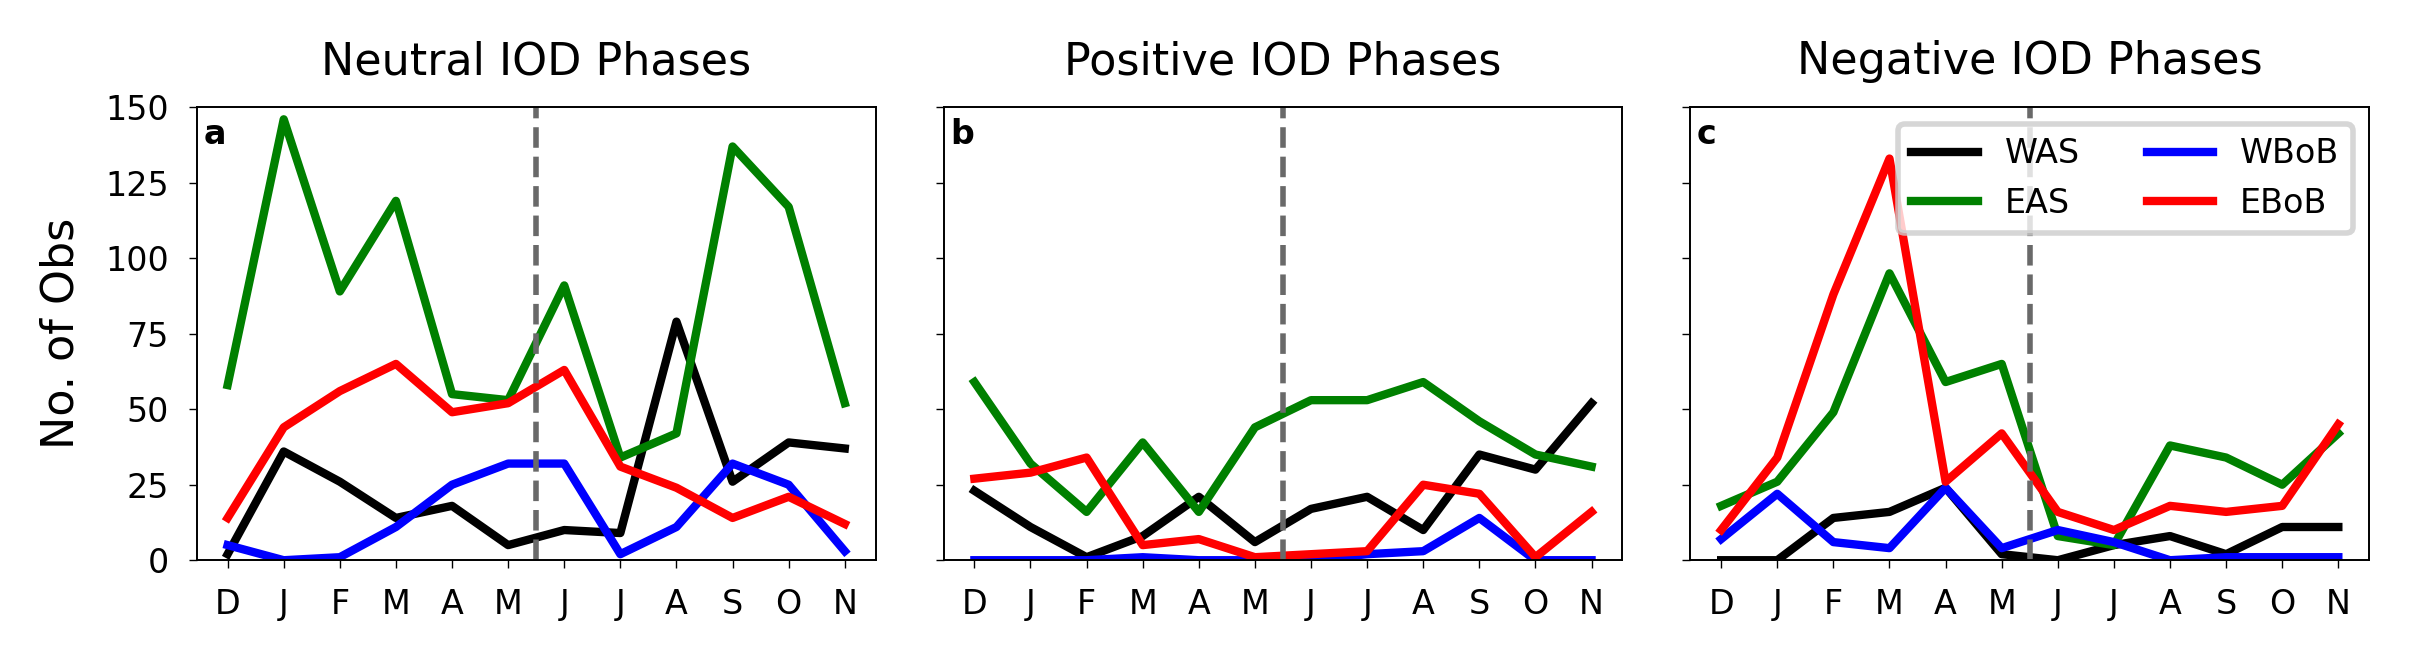

In [15]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# DMI
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
sposIODyears = list(np.array(ds_DMI.spos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

depth = '50_200'
Depth = '50-200'
############################################################################################################
# Western Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_wAS_' + depth]
lat = ds_WOD.lat_wAS
lon = ds_WOD.lon_wAS
t = ds_WOD.time_wAS

# positive IOD years -------------------------------------------# 
posIODdata_wAS,posIODlat_wAS,posIODlon_wAS,_,posIODmon_wAS,posIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wAS')
# negative IOD years -------------------------------------------# 
negIODdata_wAS,negIODlat_wAS,negIODlon_wAS,_,negIODmon_wAS,negIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_wAS,neuIODlat_wAS,neuIODlon_wAS,_,neuIODmon_wAS,neuIODseas_wAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wAS')

############################################################################################################
# Eastern Arabian Sea
############################################################################################################
doxy = ds_WOD['doxy_eAS_' + depth]
lat = ds_WOD.lat_eAS
lon = ds_WOD.lon_eAS
t = ds_WOD.time_eAS

# positive IOD years -------------------------------------------# 
posIODdata_eAS,posIODlat_eAS,posIODlon_eAS,_,posIODmon_eAS,posIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eAS')
# negative IOD years -------------------------------------------# 
negIODdata_eAS,negIODlat_eAS,negIODlon_eAS,_,negIODmon_eAS,negIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eAS')

# neutral IOD years -------------------------------------------# 
neuIODdata_eAS,neuIODlat_eAS,neuIODlon_eAS,_,neuIODmon_eAS,neuIODseas_eAS = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eAS')

############################################################################################################
# Western Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_wBoB_' + depth]
lat = ds_WOD.lat_wBoB
lon = ds_WOD.lon_wBoB
t = ds_WOD.time_wBoB

# positive IOD years -------------------------------------------# 
posIODdata_wBoB,posIODlat_wBoB,posIODlon_wBoB,_,posIODmon_wBoB,posIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'wBoB')
# negative IOD years -------------------------------------------# 
negIODdata_wBoB,negIODlat_wBoB,negIODlon_wBoB,_,negIODmon_wBoB,negIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'wBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_wBoB,neuIODlat_wBoB,neuIODlon_wBoB,_,neuIODmon_wBoB,neuIODseas_wBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'wBoB')

############################################################################################################
# Eastern Bay of Bengal
############################################################################################################
doxy = ds_WOD['doxy_eBoB_' + depth]
lat = ds_WOD.lat_eBoB
lon = ds_WOD.lon_eBoB
t = ds_WOD.time_eBoB

# positive IOD years -------------------------------------------# 
posIODdata_eBoB,posIODlat_eBoB,posIODlon_eBoB,_,posIODmon_eBoB,posIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             posIODyears, region = 'eBoB')
# negative IOD years -------------------------------------------# 
negIODdata_eBoB,negIODlat_eBoB,negIODlon_eBoB,_,negIODmon_eBoB,negIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             negIODyears, region = 'eBoB')

# neutral IOD years -------------------------------------------# 
neuIODdata_eBoB,neuIODlat_eBoB,neuIODlon_eBoB,_,neuIODmon_eBoB,neuIODseas_eBoB = IOD_year_group_WOD(doxy,
                                             lat,lon,t,
                                             IODyear_begin,IODyear_end,
                                             neuIODyears, region = 'eBoB')




fig = plt.figure(figsize=(17.8/2.54,1.5),dpi=400)

sz = 15
sq_sz = 60
fsz = 12
alpha = 0.25
lfz = 6
lw = 1.5

sp_clr = 'purple'
sat_clr = 'lightgrey'

params = {'legend.fontsize': 6,
         'axes.labelsize': 8,
         'axes.titlesize': 8,
         'xtick.labelsize':6,
         'ytick.labelsize':6}

pylab.rcParams.update(params)

letters = ['a','b','c','d','e','f','g']
mons = ['D','J','F','M','A','M','J','J','A','S','O','N']
labels = ['WAS','EAS','WBoB','EBoB']

ylim = [0,150]
##############################################################


ax = fig.add_subplot(131)

var = neuIODdata_wAS
ind = np.isnan(var)
lat = neuIODlat_wAS[~ind]
lon = neuIODlon_wAS[~ind]
mon = neuIODmon_wAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'k', lw = lw)

var = neuIODdata_eAS
ind = np.isnan(var)
lat = neuIODlat_eAS[~ind]
lon = neuIODlon_eAS[~ind]
mon = neuIODmon_eAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'g', lw = lw)

var = neuIODdata_wBoB
ind = np.isnan(var)
lat = neuIODlat_wBoB[~ind]
lon = neuIODlon_wBoB[~ind]
mon = neuIODmon_wBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'b', lw = lw)

var = neuIODdata_eBoB
ind = np.isnan(var)
lat = neuIODlat_eBoB[~ind]
lon = neuIODlon_eBoB[~ind]
mon = neuIODmon_eBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'r', lw = lw)

ax.axvline(x = 6.5, color = 'dimgray',linestyle = '--', lw = 1)

ax.set_title('Neutral IOD Phases')
ax.set_ylabel('No. of Obs')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(mons)
ax.set_ylim(ylim)
add_letter(ax, 'a', x = 0.01,y=0.92, fontsize = lfz)

#----#
ax = fig.add_subplot(132)

var = posIODdata_wAS
ind = np.isnan(var)
lat = posIODlat_wAS[~ind]
lon = posIODlon_wAS[~ind]
mon = posIODmon_wAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'k', lw = lw)

var = posIODdata_eAS
ind = np.isnan(var)
lat = posIODlat_eAS[~ind]
lon = posIODlon_eAS[~ind]
mon = posIODmon_eAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'g', lw = lw)

var = posIODdata_wBoB
ind = np.isnan(var)
lat = posIODlat_wBoB[~ind]
lon = posIODlon_wBoB[~ind]
mon = posIODmon_wBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'b', lw = lw)

var = posIODdata_eBoB
ind = np.isnan(var)
lat = posIODlat_eBoB[~ind]
lon = posIODlon_eBoB[~ind]
mon = posIODmon_eBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'r', lw = lw)

ax.axvline(x = 6.5, color = 'dimgray',linestyle = '--', lw = 1)
ax.set_title('Positive IOD Phases')
ax.set_yticklabels([])
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(mons)
ax.set_ylim(ylim)
add_letter(ax, 'b', x = 0.01,y=0.92, fontsize = lfz)

#----#
ax = fig.add_subplot(133)

var = negIODdata_wAS
ind = np.isnan(var)
lat = negIODlat_wAS[~ind]
lon = negIODlon_wAS[~ind]
mon = negIODmon_wAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'k', lw = lw, label = labels[0])

var = negIODdata_eAS
ind = np.isnan(var)
lat = negIODlat_eAS[~ind]
lon = negIODlon_eAS[~ind]
mon = negIODmon_eAS[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'g', lw = lw, label = labels[1])

var = negIODdata_wBoB
ind = np.isnan(var)
lat = negIODlat_wBoB[~ind]
lon = negIODlon_wBoB[~ind]
mon = negIODmon_wBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'b', lw = lw, label = labels[2])

var = negIODdata_eBoB
ind = np.isnan(var)
lat = negIODlat_eBoB[~ind]
lon = negIODlon_eBoB[~ind]
mon =negIODmon_eBoB[~ind]

mon_cnt = []
for tt in range(1,13):
    mon_cnt.append(np.nansum(mon == tt))

# roll so december is first
mon_cnt = np.array(mon_cnt)
mon_cnt = np.roll(mon_cnt,1)

p = ax.plot(np.arange(1,13), mon_cnt, color = 'r', lw = lw, label = labels[3])

ax.axvline(x = 6.5, color = 'dimgray',linestyle = '--', lw = 1)
ax.set_title('Negative IOD Phases')
ax.set_yticklabels([])
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(mons)
ax.set_ylim(ylim)
add_letter(ax, 'c', x = 0.01,y=0.92, fontsize = lfz)

plt.subplots_adjust(wspace = 0.1)
plt.legend(markerscale=5, ncol = 2, loc = 'upper right')

plt.savefig(figpath + 'Fig_S21_o2_obs_per_month_iod_phase.pdf', format='pdf', dpi = 400)

# S22 - Locations of Observations used in Correlations

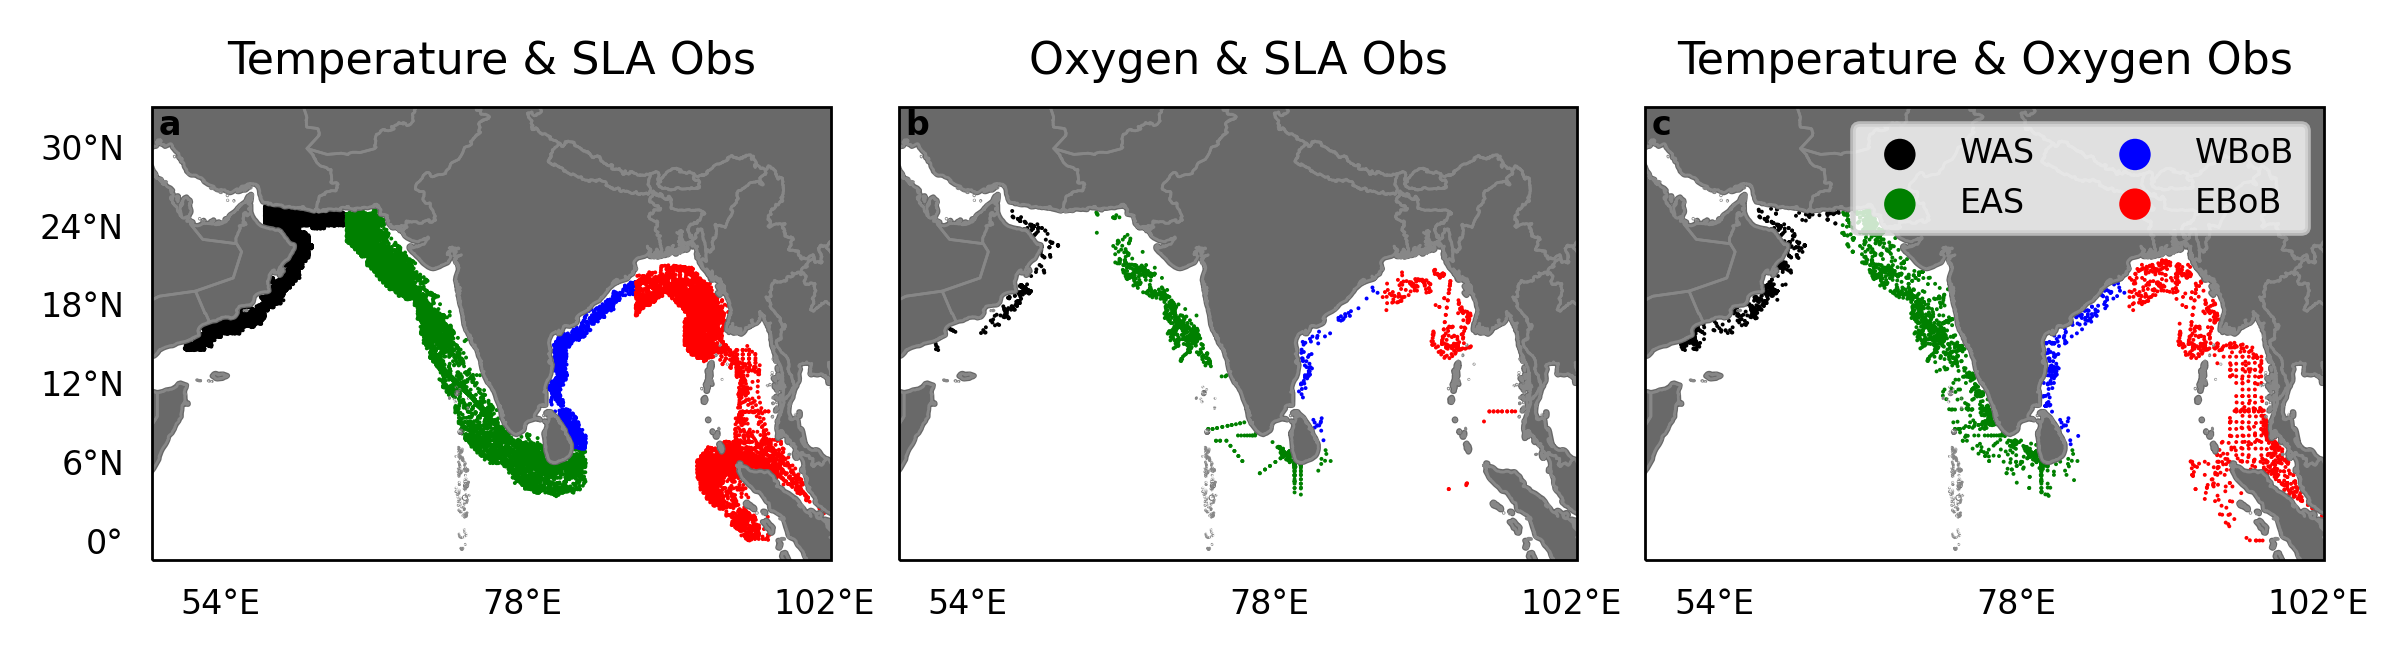

In [17]:
#WOD
ds_WOD = xr.open_dataset('../data_processing/1_WOD_Coastal/wod_coastal_processed.nc')

# SLA
ds_SLA = xr.open_dataset('../data_processing/6_Regridding/sla_to_wod.nc')

depth = '50_200'
Depth = '50-200'
############################################################################
doxy_wAS = ds_WOD['doxy_wAS_' + depth]
doxy_eAS = ds_WOD['doxy_eAS_' + depth]
doxy_wBoB = ds_WOD['doxy_wBoB_' + depth]
doxy_eBoB = ds_WOD['doxy_eBoB_' + depth]

sla_wAS = ds_SLA['sla_wAS']
sla_eAS = ds_SLA['sla_eAS']
sla_wBoB = ds_SLA['sla_wBoB']
sla_eBoB = ds_SLA['sla_eBoB']

seas_wAS = ds_WOD['seas_wAS']
seas_eAS = ds_WOD['seas_eAS']
seas_wBoB = ds_WOD['seas_wBoB']
seas_eBoB = ds_WOD['seas_eBoB']

temp_wAS = ds_WOD['temp_wAS_' + depth]
temp_eAS = ds_WOD['temp_eAS_' + depth]
temp_wBoB = ds_WOD['temp_wBoB_' + depth]
temp_eBoB = ds_WOD['temp_eBoB_' + depth]

lat_wAS = ds_SLA['lat_wAS']
lat_eAS = ds_SLA['lat_eAS']
lat_wBoB = ds_SLA['lat_wBoB']
lat_eBoB = ds_SLA['lat_eBoB']

lon_wAS = ds_SLA['lon_wAS']
lon_eAS = ds_SLA['lon_eAS']
lon_wBoB = ds_SLA['lon_wBoB']
lon_eBoB = ds_SLA['lon_eBoB']
##############################################################
fig = plt.figure(figsize=(17.8/2.54,1.5),dpi=400)

sz = 2
sq_sz = 60
fsz = 12
alpha = 0.25
lfz = 6

sp_clr = 'purple'
sat_clr = 'lightgrey'

params = {'legend.fontsize': 6,
         'axes.labelsize': 8,
         'axes.titlesize': 8,
         'xtick.labelsize':6,
         'ytick.labelsize':6}

pylab.rcParams.update(params)

##############################################################
ax = fig.add_subplot(131,projection= ccrs.PlateCarree())
ind = np.isnan(sla_wAS) | np.isnan(temp_wAS)
p = ax.scatter(lon_wAS[~ind],lat_wAS[~ind], c='k', marker = '.', 
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_eAS) | np.isnan(temp_eAS)
p = ax.scatter(lon_eAS[~ind],lat_eAS[~ind], c='g', marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_wBoB) | np.isnan(temp_wBoB)
p = ax.scatter(lon_wBoB[~ind],lat_wBoB[~ind], c='b', marker = '.', 
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_eBoB) | np.isnan(temp_eBoB)
p = ax.scatter(lon_eBoB[~ind],lat_eBoB[~ind], c='r', marker = '.', 
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ax.set_title('Temperature & SLA Obs')
g = add_land(ax,bounds = cm_bounds, countries = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 6}
g.ylabel_style = {'size': 6}
add_letter(ax, 'a', x = 0.01,y=0.94, fontsize = lfz)

ax = fig.add_subplot(132,projection= ccrs.PlateCarree())
ind = np.isnan(sla_wAS) | np.isnan(doxy_wAS)
p = ax.scatter(lon_wAS[~ind],lat_wAS[~ind], c='k',marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_eAS) | np.isnan(doxy_eAS)
p = ax.scatter(lon_eAS[~ind],lat_eAS[~ind], c='g',marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_wBoB) | np.isnan(doxy_wBoB)
p = ax.scatter(lon_wBoB[~ind],lat_wBoB[~ind], c='b', marker = '.', 
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ind = np.isnan(sla_eBoB) | np.isnan(doxy_eBoB)
lep = ax.scatter(lon_eBoB[~ind],lat_eBoB[~ind], c='r', marker = '.', 
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree())
ax.set_title('Oxygen & SLA Obs')
g = add_land(ax,bounds = cm_bounds, countries = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 6}
g.ylabel_style = {'size': 6}
g.ylabels_left = False
add_letter(ax, 'b', x = 0.01,y=0.94, fontsize = lfz)

ax = fig.add_subplot(133,projection= ccrs.PlateCarree())
ind = np.isnan(doxy_wAS) | np.isnan(temp_wAS)
p = ax.scatter(lon_wAS[~ind],lat_wAS[~ind], c='k', marker = '.',
               edgecolor = 'none', s = sz,transform=ccrs.PlateCarree(), label = 'WAS')
ind = np.isnan(doxy_eAS) | np.isnan(temp_eAS)
p = ax.scatter(lon_eAS[~ind],lat_eAS[~ind], c='g',  marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree(), label = 'EAS')
ind = np.isnan(doxy_wBoB) | np.isnan(temp_wBoB)
p = ax.scatter(lon_wBoB[~ind],lat_wBoB[~ind], c='b',  marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree(), label = 'WBoB')
ind = np.isnan(doxy_eBoB) | np.isnan(temp_eBoB)
p = ax.scatter(lon_eBoB[~ind],lat_eBoB[~ind], c='r',  marker = '.',
               edgecolor = 'none',s = sz,transform=ccrs.PlateCarree(), label = 'EBoB')
ax.set_title('Temperature & Oxygen Obs')
g = add_land(ax,bounds = cm_bounds, countries = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 6}
g.ylabel_style = {'size': 6}
g.ylabels_left = False
add_letter(ax, 'c', x = 0.01,y=0.94, fontsize = lfz)

plt.subplots_adjust(wspace = 0.1)
plt.legend(markerscale=8, ncol = 2, loc = 'upper right')

plt.savefig(figpath + 'Fig_S22_sla_corr_doxy_temp_loc_map_' + depth + '.pdf', format='pdf', dpi = 400)

# S23 - Neutral IOD Phases

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


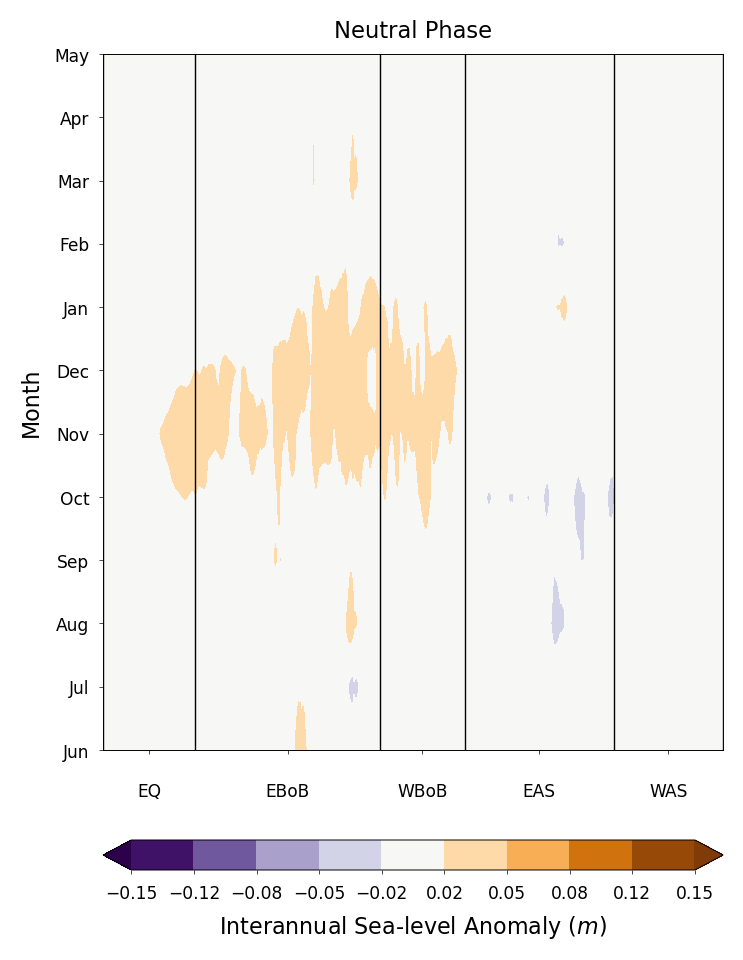

In [21]:
# SLA
ds_SLA = xr.open_dataset('../data_processing/2_SLA/sla_processed.nc')
mon_sla_mon_anom = ds_SLA['mon_sla_mon_anom']
lat = mon_sla_mon_anom.lat.values
lon = mon_sla_mon_anom.lon.values

# load DMI data
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')

neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# average over the neutral IOD years -------------------------------------------# 
neuIOD_mon_sla_mon_anom,_ = IOD_year_group_grid(mon_sla_mon_anom,IODyear_begin,IODyear_end,neuIODyears)

# create list of integer years
IODphases = list([neuIOD_mon_sla_mon_anom])
titles = ['Neutral Phase']
# plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(4, 6), dpi = 200)

cmin = -0.15
cmax = 0.15

letters = ['a','b','c','d','e','f']

params = {'legend.fontsize': 6,
         'axes.labelsize': 8,
         'axes.titlesize': 8.15,
         'xtick.labelsize':6.15,
         'ytick.labelsize':6.15,
         'hatch.linewidth':0.5,
         'hatch.color':'#3A3B3C'}

pylab.rcParams.update(params)

#########################

for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],ds_SLA.sta_loninds.shape[0]])
    ac = np.zeros([vtimes.shape[0],ds_SLA.sta_loninds.shape[0]])
    
    for jj in range(ds_SLA.sta_loninds.shape[0]):
        data[:,jj] = phase[:,ds_SLA.sta_latinds[jj],ds_SLA.sta_loninds[jj]]

    # colorbar limits
    levels = np.round(np.linspace(cmin, cmax, 10),2)

    # Specify longitude values for chosen domain
    sta = np.arange(len(ds_SLA.sta_loninds))

    ax = fig.add_subplot(1,1,ii+1)

    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")

    
    for loc in ds_SLA.loc_list:
        plt.axvline(x=loc,color = 'k', linewidth = 0.5)
        
#     plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    if ii == 0:
        ax.set_yticklabels(['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar', 'Apr', 'May'])
    else:
        ax.set_yticklabels([])
        
    xticks = (np.array(ds_SLA.loc_list[:-1]) + np.array(ds_SLA.loc_list[1:]))*0.5
    ax.set_xticks(xticks)
    ax.set_xticklabels(['EQ', 'EBoB','WBoB', 'EAS','WAS'])
    ax.tick_params(axis='x', which='major', pad=10)
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
#     add_letter(ax, letters[ii], x = 0.01,y=0.955, fontsize = 7)

# cbar_ax = fig.add_axes([0.91, 0.125, 0.015, 0.75])
cbar_ax = fig.add_axes([0.125, 0.2, 0.775, 0.025])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04, orientation = 'horizontal')
cbar.set_label('Interannual Sea-level Anomaly ($m$)')

plt.subplots_adjust(wspace = 0.15, bottom = 0.3)

plt.savefig(figpath + 'Fig_S23_sla_neutral.pdf', format='pdf', dpi = 400)

# S24 - Difference in upwelling for strong posIOD phases and all posIOD phases

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


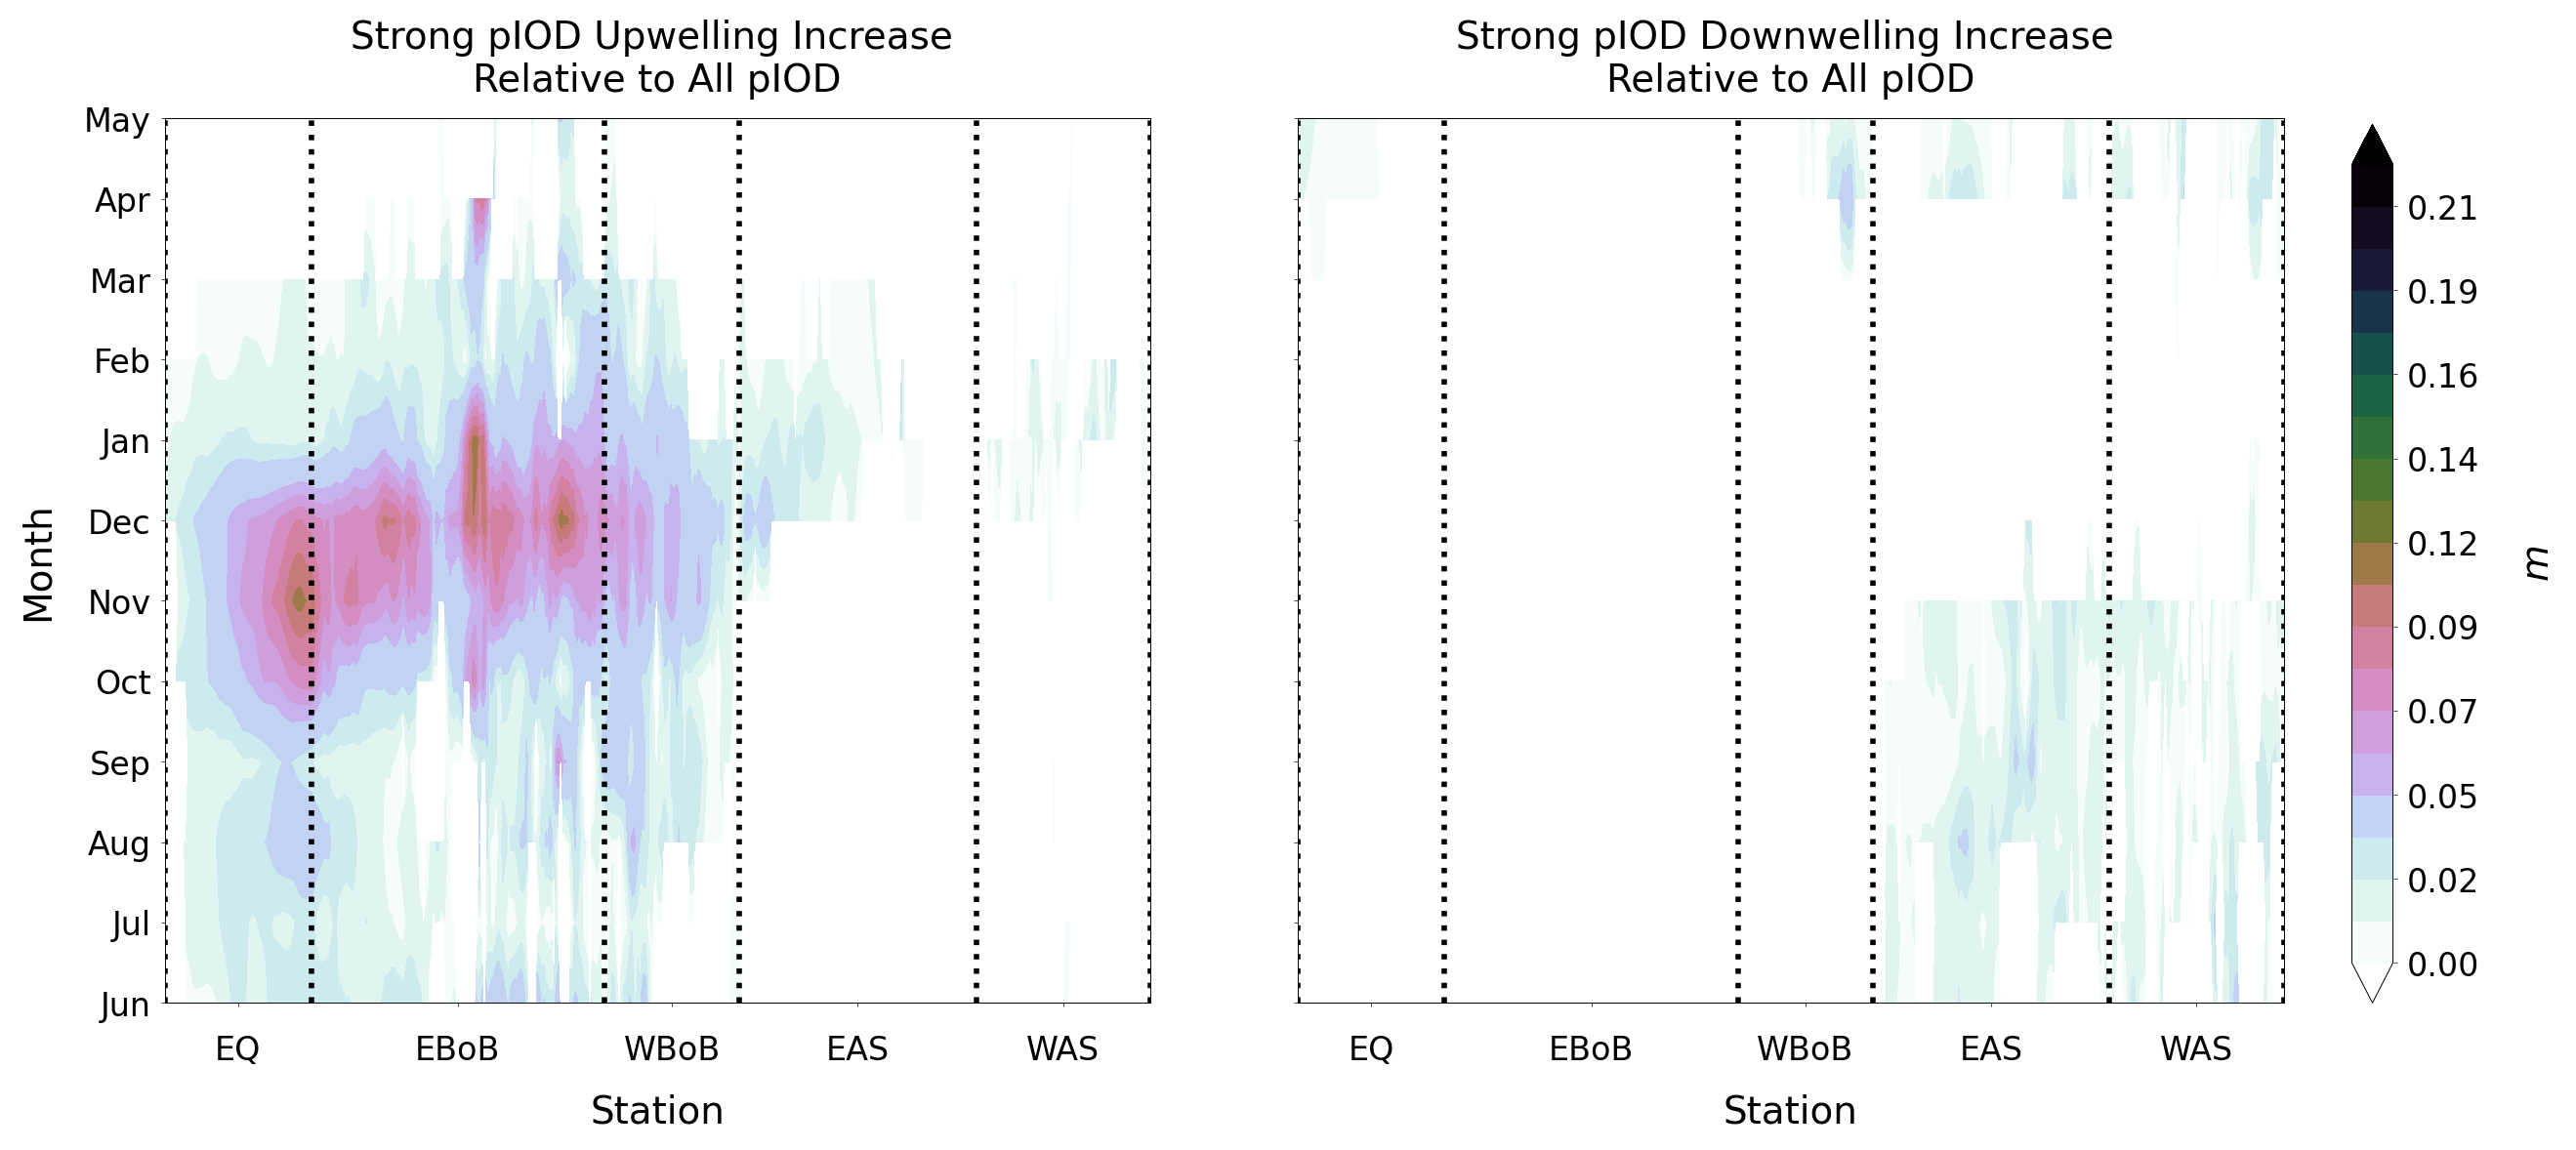

In [23]:
# SLA
ds_SLA = xr.open_dataset('../data_processing/2_SLA/sla_processed.nc')
ds_SLA

mon_sla_mon_anom = ds_SLA['mon_sla_mon_anom']
mon_sla_mon_clim = ds_SLA['mon_sla_mon_clim']
lat = mon_sla_mon_anom.lat.values
lon = mon_sla_mon_anom.lon.values

# load DMI data
ds_DMI= xr.open_dataset('../data_processing/3_DMI/dmi_processed.nc')
posIODyears = list(np.array(ds_DMI.pos_IOD_years)) 
sposIODyears = list(np.array(ds_DMI.spos_IOD_years)) 

# average over the positive IOD years
posIOD_mon_sla_mon_anom,_ = IOD_year_group_grid(mon_sla_mon_anom,IODyear_begin,IODyear_end,posIODyears)
# average over the strong positive IOD years
sposIOD_mon_sla_mon_anom,_ = IOD_year_group_grid(mon_sla_mon_anom,IODyear_begin,IODyear_end,sposIODyears)
# annual cycle
mon_sla_mon_clim = mon_sla_mon_clim.roll(month=-5,roll_coords = False)

# create list of integer years
IODphases = list([mon_sla_mon_clim,
                  sposIOD_mon_sla_mon_anom,
                  posIOD_mon_sla_mon_anom])
titles = ['Strong pIOD Upwelling Increase \nRelative to All pIOD', 
          'Strong pIOD Downwelling Increase \nRelative to All pIOD']

fig = plt.figure(figsize=(14, 6), dpi = 200)

cmin = 0
cmax = .22

params = {'legend.fontsize': 8,
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize':12,
         'ytick.labelsize':12}

pylab.rcParams.update(params)

letters = ['a','b','c','d']

#########################
for ii in range(2):
    
    # Get times and make array of datetime objects
    vtimes = mon_sla_mon_clim.month
    
    data1 = np.zeros([vtimes.shape[0],ds_SLA.sta_loninds.shape[0]])
    data2 = np.zeros([vtimes.shape[0],ds_SLA.sta_loninds.shape[0]])
    data3 = np.zeros([vtimes.shape[0],ds_SLA.sta_loninds.shape[0]])
    for jj in range(ds_SLA.sta_loninds.shape[0]):
        data1[:,jj] = sposIOD_mon_sla_mon_anom[:,ds_SLA.sta_latinds[jj],ds_SLA.sta_loninds[jj]]
        data2[:,jj] = posIOD_mon_sla_mon_anom[:,ds_SLA.sta_latinds[jj],ds_SLA.sta_loninds[jj]]
        data3[:,jj] = mon_sla_mon_clim[:,ds_SLA.sta_latinds[jj],ds_SLA.sta_loninds[jj]]
        
    # data1 = seasonal cycle    |   data2 = all pIODs     |    data3 = spIODs

    if ii == 0: # extra upwelling in spIODs compared to all  pIODs
        data = (np.abs(data1)-np.abs(data2))

        ind = (data1 < 0) & (data2 < 0) & (data > 0)
        data[~ind] = np.nan
    else:# extra downwelling in spIODs compared to all  pIODs
        data = (np.abs(data1)-np.abs(data2))
        
        ind = (data1 > 0) & (data2 > 0) & (data > 0)
        data[~ind] = np.nan
    
    # colorbar limits
    levels = np.round(np.linspace(cmin, cmax, 20),2)

    # Specify longitude values for chosen domain
    sta = np.arange(len(ds_SLA.sta_loninds))

    ax = fig.add_subplot(1,2,ii+1)

    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.cubehelix_r, extend="both")


    for loc in ds_SLA.loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':', linewidth = 2) 
    plt.xlabel('Station', labelpad = 10)
    if (ii == 0):
        plt.ylabel('Month', labelpad = 10)
    
    plt.title(titles[ii], pad = 10)
    if ii == 0:
        ax.set_yticklabels(['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar', 'Apr', 'May'])
    else:
        ax.set_yticklabels([])
    xticks = (np.array(ds_SLA.loc_list[:-1]) + np.array(ds_SLA.loc_list[1:]))*0.5
    ax.set_xticks(xticks)
    ax.set_xticklabels(['EQ', 'EBoB','WBoB', 'EAS','WAS'])
    ax.tick_params(axis='x', which='major', pad=10)
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
#     add_letter(ax, letters[ii], x = 0.01,y=0.94, fontsize = 26)

cbar_ax = fig.add_axes([0.925, 0.125, 0.015, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('$m$', labelpad = 15)

plt.subplots_adjust(wspace = 0.15, right = 0.9)

plt.savefig(figpath + 'Fig_S24_upwelling_spiod_vs_piod.pdf', format='pdf', dpi = 400)


